In [14]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg, scipy.signal
import pint
import tqdm
import multiprocessing

from multiprocessing import Pool, cpu_count

from hsds_np import *
from bipartite_hartree import BipartiteHartreeSolver

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
SAVEFIGS = True

The anodes have units of $[\epsilon]^{-1}$ to ensure that multiplication with the coupling constants (typically given in units of $[\epsilon]$) gives a dimensionless contribution.
We multiply the anodes by a factor $\epsilon$ in electron-volts to ensure that they are dimensionless.
Similarly for the couplings constants we multiply by $\epsilon^{-1}$ in electron-volts to get dimensionless values for these.
The grid is given in units of $[\lambda]$.

In [3]:
data = np.loadtxt("anodic_well_basis.txt")

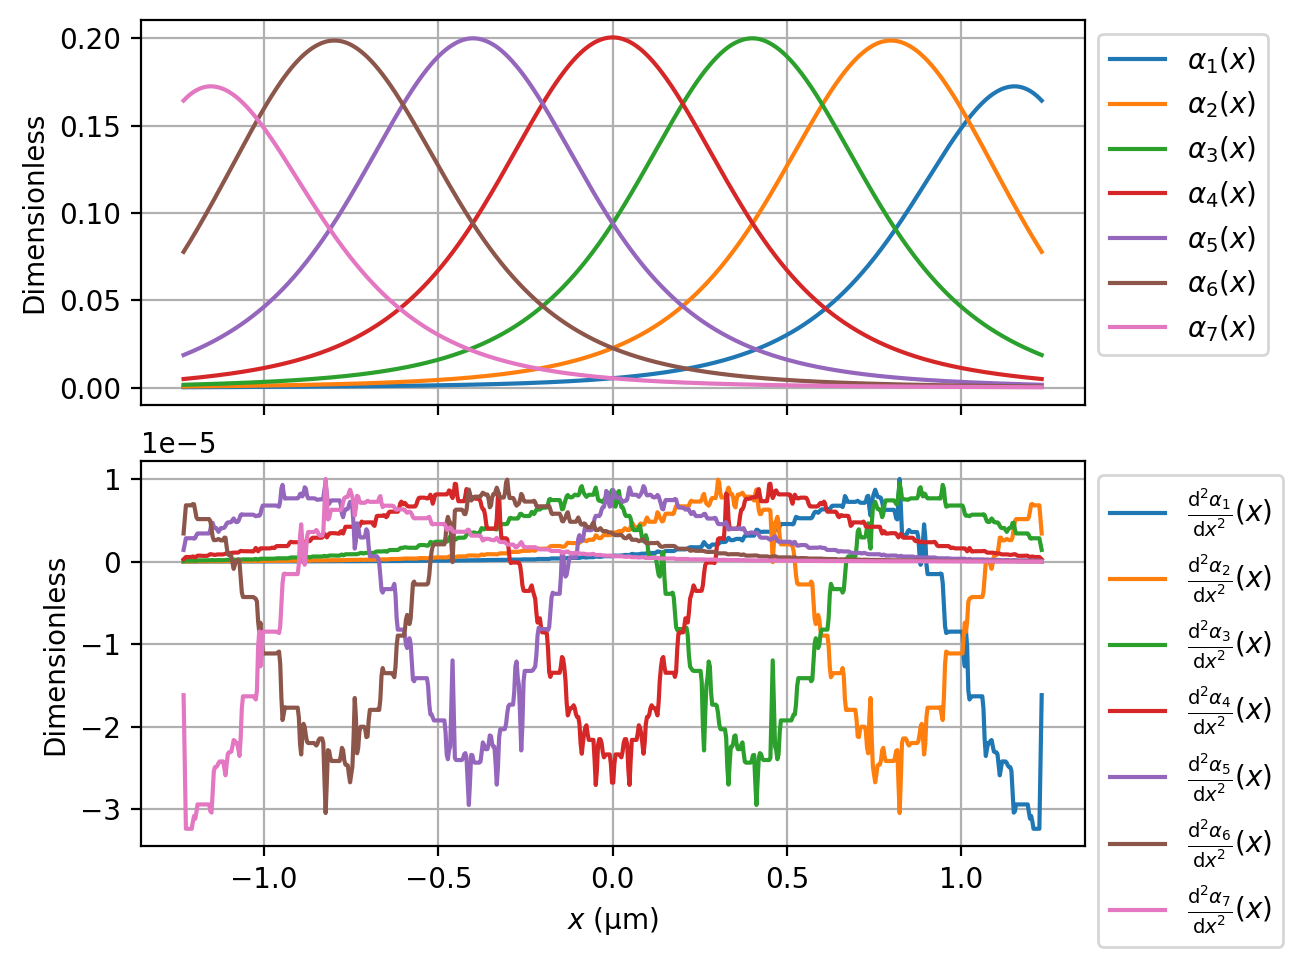

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, layout="constrained")

x = data[:, 0]

for i in range(1, data.shape[1]):
    mask = (x > -10) & (x < 10)
    # mask = slice(0, len(data[:, 0]))
    axs[0].plot(
        # Grid in units of "length", converted to micrometers
        x[mask] * length.to(ureg.micrometer).magnitude,
        data[mask, i] * epsilon.to(ureg.eV).magnitude,
        label=r"$\alpha_{" + f"{i}" + r"}(x)$",
    )
    axs[1].plot(
        x[mask] * length.to(ureg.micrometer).magnitude,
        np.gradient(np.gradient(data[mask, i] * epsilon.to(ureg.eV).magnitude)),
        label=r"$\frac{\mathrm{d}^2\alpha_{" + f"{i}" + r"}}{\mathrm{d} x^2}(x)$",
    )

axs[1].set_xlabel(r"$x$ ($\mathrm{\mu}$m)")
axs[0].set_ylabel("Dimensionless")
axs[1].set_ylabel("Dimensionless")
axs[0].grid()
axs[1].grid()
axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend(bbox_to_anchor=(1, 1))
plt.show()

Save anodes.

In [5]:
if SAVEFIGS:
    # Save anodes
    dir_path = os.path.join("dat", "anodes")
    try:
        os.mkdir(dir_path)
    except FileExistsError:
        pass

    for i in range(1, data.shape[1]):
        np.savetxt(
            os.path.join(dir_path, f"alpha_{i}.txt"),
            np.concatenate(
                [
                    data[:, 0][:, None] * length.to(ureg.micrometer).magnitude,
                    data[:, i][:, None] * epsilon.to(ureg.eV).magnitude,
                ],
                axis=1,
            ),
            header="x [um] | a [dimensionless]",
        )

In [6]:
anodes = get_anodes()

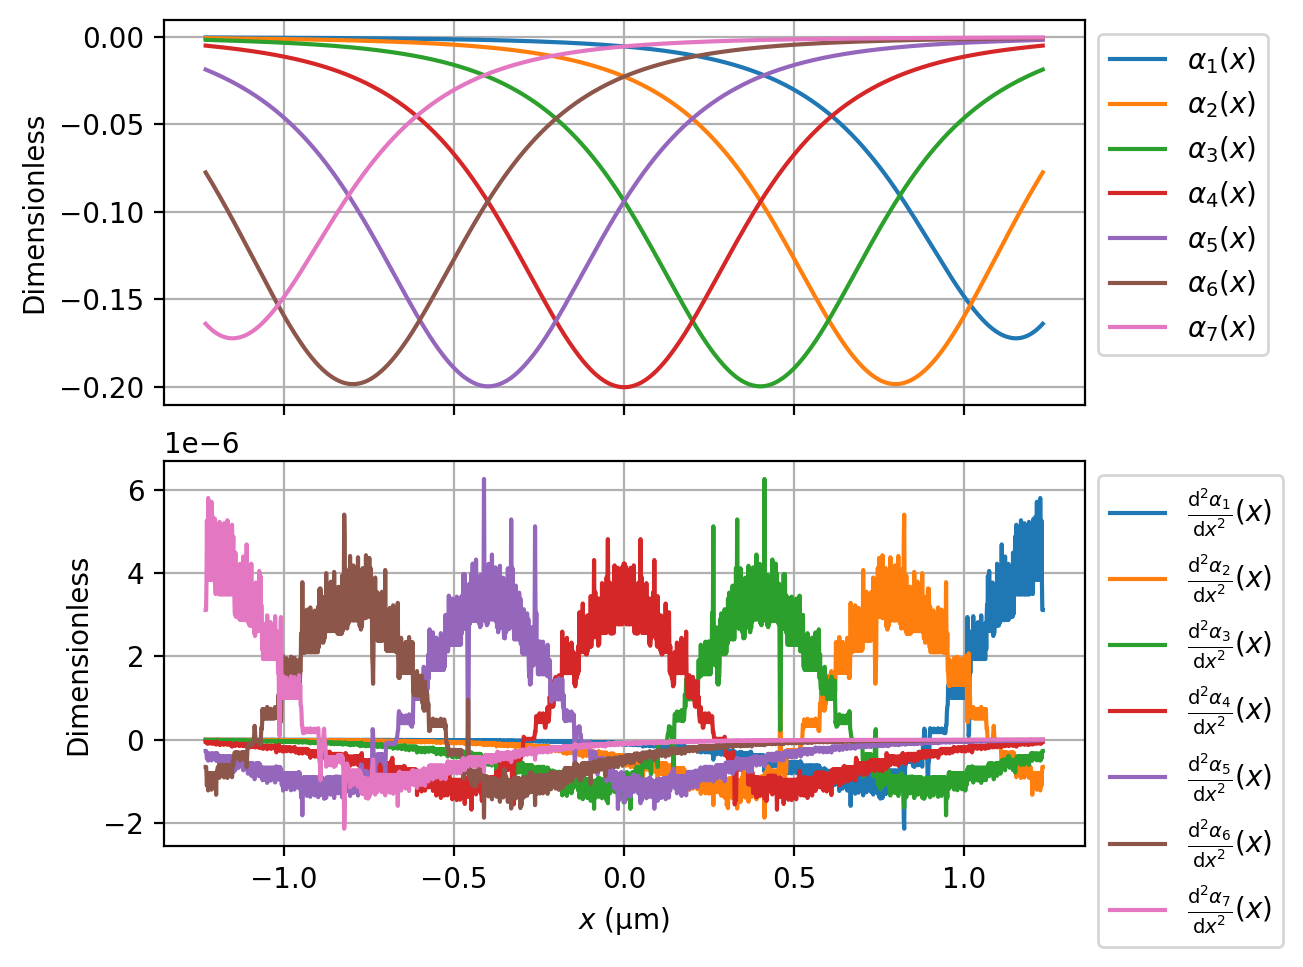

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, layout="constrained")

x = np.linspace(-10, 10, 2001)

for i in range(1, data.shape[1]):
    key = f"V{i}"
    axs[0].plot(
        x * length.to(ureg.micrometer).magnitude,
        anodes[key](x),
        label=r"$\alpha_{" + f"{i}" + r"}(x)$",
    )
    axs[1].plot(
        x * length.to(ureg.micrometer).magnitude,
        np.gradient(np.gradient(anodes[key](x))),
        label=r"$\frac{\mathrm{d}^2\alpha_{" + f"{i}" + r"}}{\mathrm{d} x^2}(x)$",
    )

axs[1].set_xlabel(r"$x$ ($\mathrm{\mu}$m)")
axs[0].set_ylabel("Dimensionless")
axs[1].set_ylabel("Dimensionless")
axs[0].grid()
axs[1].grid()
axs[0].legend(bbox_to_anchor=(1, 1))
axs[1].legend(bbox_to_anchor=(1, 1))
plt.show()

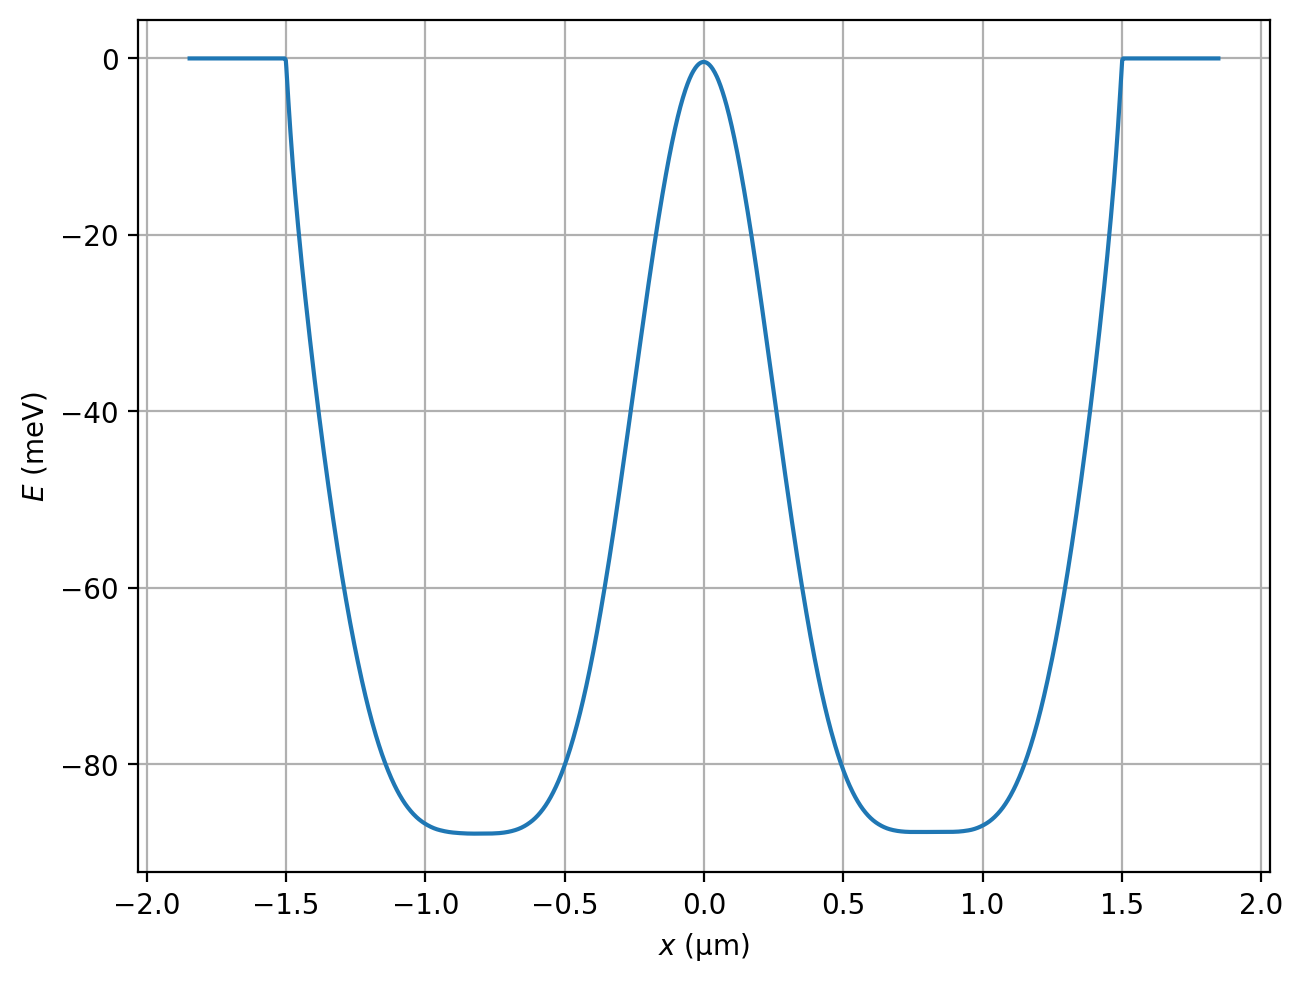

In [8]:
x = np.linspace(-15, 15, 2001)

fig, ax = plt.subplots(nrows=1, ncols=1, layout="constrained")

ax.plot(
    x * length.to(ureg.micrometer).magnitude,
    Potential(0)(x) * epsilon.to(ureg.millieV).magnitude,
)
ax.grid()
ax.set_xlabel(r"$x$ ($\mathrm{\mu}$m)")
ax.set_ylabel(r"$E$ (meV)")

plt.show()

In order to split up into two wells, one for the left system, and another for the right, we locate the point where the potential barrier is maximum and split the wells there.

In [9]:
(
    x_l,
    x_r,
    x_min_l,
    x_min_r,
    x_barrier,
    potential_l,
    potential_r,
    potential,
) = get_split_wells(0.74, x)

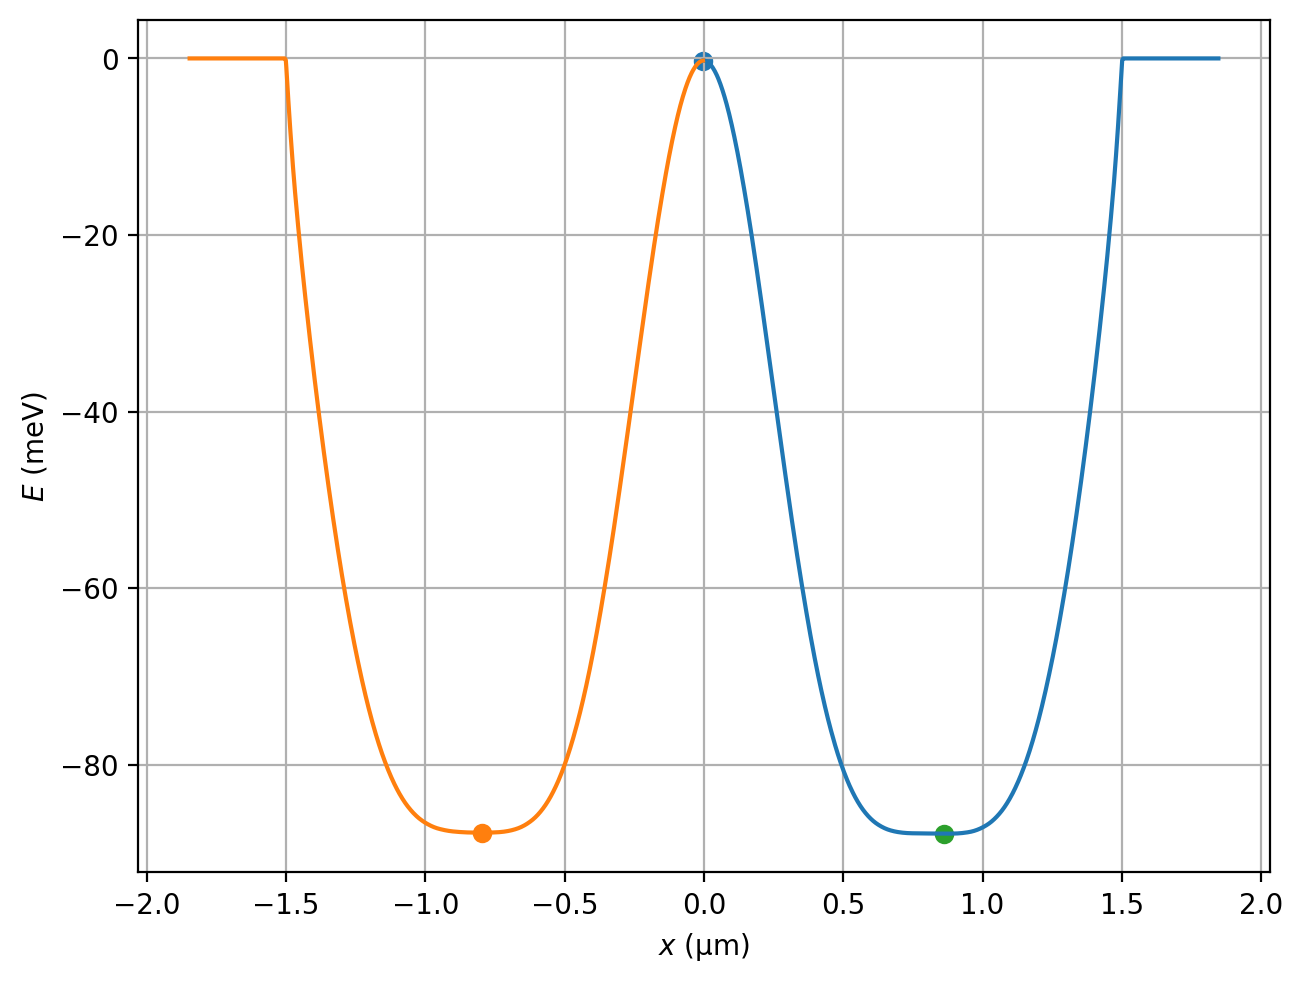

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, layout="constrained")

ax.plot(
    x_r * length.to(ureg.micrometer).magnitude,
    potential_r(x_r) * epsilon.to(ureg.millieV).magnitude,
)
ax.plot(
    x_l * length.to(ureg.micrometer).magnitude,
    potential_l(x_l) * epsilon.to(ureg.millieV).magnitude,
)
ax.scatter(
    x_barrier * length.to(ureg.micrometer).magnitude,
    potential_r(x_barrier) * epsilon.to(ureg.millieV).magnitude,
)
ax.scatter(
    x_min_l * length.to(ureg.micrometer).magnitude,
    potential(x_min_l) * epsilon.to(ureg.millieV).magnitude,
)
ax.scatter(
    x_min_r * length.to(ureg.micrometer).magnitude,
    potential(x_min_r) * epsilon.to(ureg.millieV).magnitude,
)
ax.grid()
ax.set_xlabel(r"$x$ ($\mathrm{\mu}$m)")
ax.set_ylabel(r"$E$ (meV)")

plt.show()

In [11]:
# num_lambdas = 201
# lambdas = [2 * i / (num_lambdas - 1) for i in range(num_lambdas)]

In [11]:
# Add extra points at designated locations
lambdas = sorted(
    set(
        np.round(
            np.concatenate(
                [
                    np.linspace(0, 0.5, 26),
                    np.linspace(0.5, 0.6, 51),
                    np.linspace(0.6, 0.95, 36),
                    np.linspace(0.95, 1.05, 51),
                    np.linspace(1.05, 2.05, 51),
                ],
            ),
            7,
        )
    )
)
num_lambdas = len(lambdas)

In [12]:
def f(c):
    return LiquidHeliumSincDvrSystem(
        c,
        num_basis_l=8,
        num_basis_r=8,
        num_two_body_eigenstates=10,
    )

In [15]:
if sys.platform != "darwin":
    with multiprocessing.Pool() as p:
        lhsdss = p.map(
            f,
            lambdas,
        )

    lhsds_dict = {lhs.c_lambda: lhs for lhs in lhsdss}

In [15]:
n_cores = cpu_count()
print(f"avaliable cores for computations - {n_cores - 2}")

avaliable cores for computations - 8


In [ ]:
if __name__ ==  '__main__':
    if sys.platform == "darwin":
        # On mac we have to use this
        with Pool(n_cores - 2) as p:
            lhsdss = p.imap_unordered(
                get_system,
                lambdas,
            )

        lhsds_dict = {lhs.c_lambda: lhs for lhs in lhsdss}

In [17]:
lhsdss = []
for item in tqdm.tqdm(lambdas):
    lhsdss.append(get_system(item))

lhsds_dict = {lhs.c_lambda: lhs for lhs in lhsdss}

100%|██████████| 211/211 [02:25<00:00,  1.45it/s]


In [18]:
num_basis_l = lhsds_dict[0].num_basis_l
num_basis_r = lhsds_dict[0].num_basis_r
num_two_body_eigenstates = lhsds_dict[0].num_two_body_eigenstates

In [19]:
s_keys = sorted(lhsds_dict)
entropies_1 = [lhsds_dict[key].entropies[1] for key in s_keys]
config_II_key = s_keys[np.argmax(entropies_1)]
print(config_II_key)

0.554


In [20]:
configs = {
    "I": lhsds_dict[0],
    "II": lhsds_dict[config_II_key],
    "III": lhsds_dict[1.0],
}

In [21]:
lhsds = lhsds_dict[0]

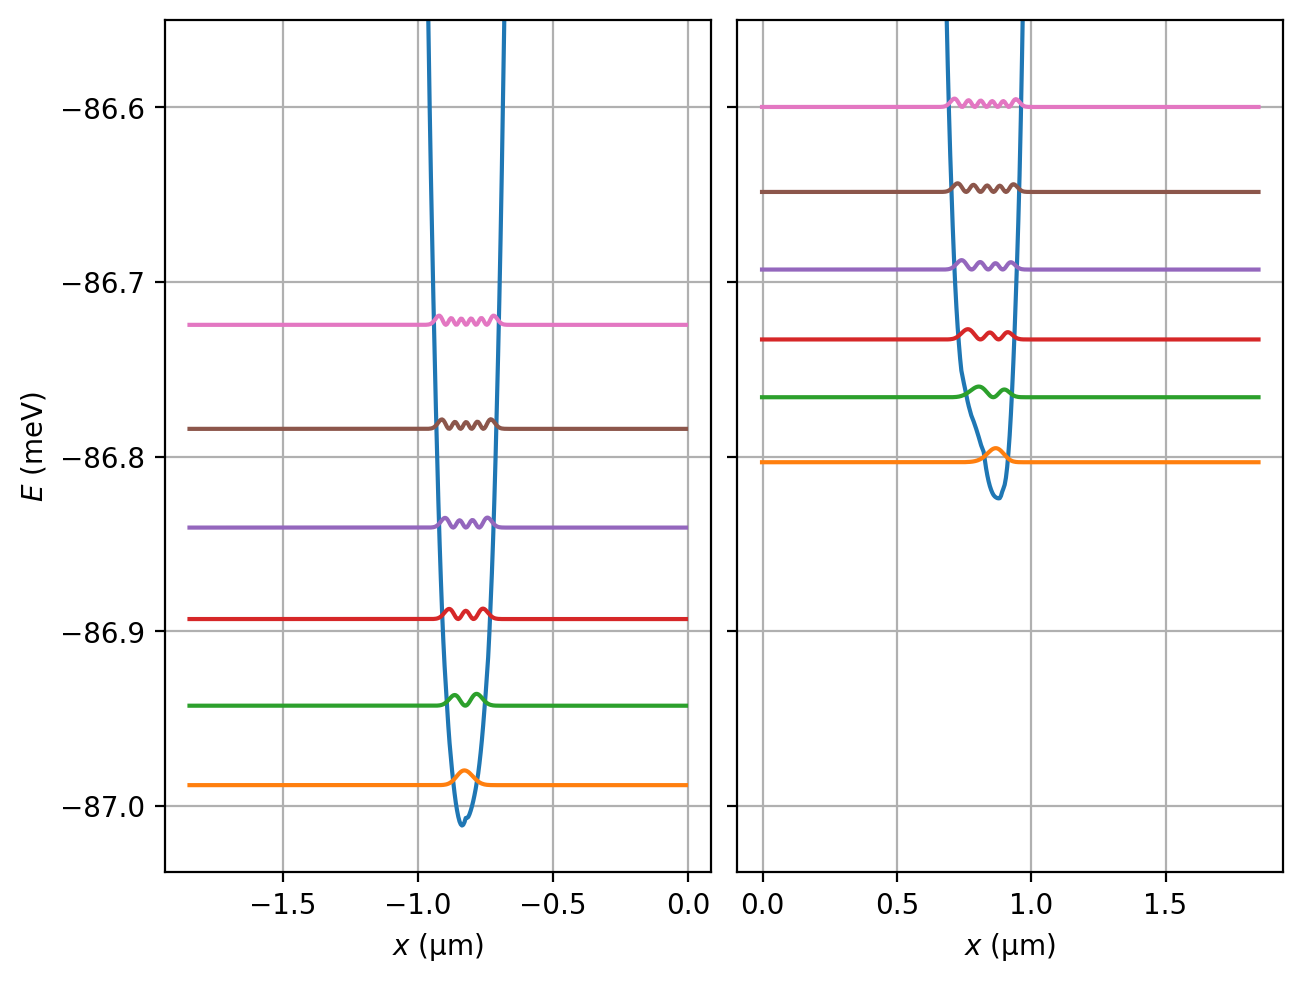

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, layout="constrained", sharey=True)

axs[0].plot(
    lhsds.x_l * length.to(ureg.micrometer).magnitude,
    lhsds.potential_l_eff(lhsds.x_l) * epsilon.to(ureg.millieV).magnitude,
)

num_plots = min(6, min(lhsds.num_basis_l, lhsds.num_basis_r))

for i in range(num_plots):
    axs[0].plot(
        lhsds.x_l * length.to(ureg.micrometer).magnitude,
        ((lhsds.spf_l[i]) ** 2 + lhsds.eps_l[i]) * epsilon.to(ureg.millieV).magnitude,
    )
axs[0].grid()
axs[0].set_xlabel(r"$x$ ($\mathrm{\mu}$m)")
axs[0].set_ylabel(r"$E$ (meV)")

axs[1].plot(
    lhsds.x_r * length.to(ureg.micrometer).magnitude,
    lhsds.potential_r_eff(lhsds.x_r) * epsilon.to(ureg.millieV).magnitude,
)

for i in range(num_plots):
    axs[1].plot(
        lhsds.x_r * length.to(ureg.micrometer).magnitude,
        ((lhsds.spf_r[i]) ** 2 + lhsds.eps_r[i]) * epsilon.to(ureg.millieV).magnitude,
    )
axs[1].grid()
axs[1].set_xlabel(r"$x$ ($\mathrm{\mu}$m)")
axs[1].set_ylim(
    [
        min(lhsds.eps_l[0], lhsds.eps_r[0]) * epsilon.to(ureg.millieV).magnitude - 0.05,
        max(
            lhsds.eps_l[num_plots - 1],
            lhsds.eps_r[num_plots - 1],
        )
        * epsilon.to(ureg.millieV).magnitude
        + 0.05,
    ]
)

plt.show()

Save single-particle functions.

In [23]:
if SAVEFIGS:
    dir_path = os.path.join("dat", "spfs")
    try:
        os.mkdir(dir_path)
    except FileExistsError:
        pass

    np.savetxt(
        os.path.join(dir_path, f"potential_eff_l.txt"),
        np.concatenate(
            [
                lhsds.x_l[:, None] * length.to(ureg.micrometer).magnitude,
                lhsds.potential_l_eff(lhsds.x_l)[:, None]
                * epsilon.to(ureg.millieV).magnitude,
            ],
            axis=1,
        ),
        header="x [um] | potential [millieV]",
    )

    np.savetxt(
        os.path.join(dir_path, f"potential_eff_r.txt"),
        np.concatenate(
            [
                lhsds.x_r[:, None] * length.to(ureg.micrometer).magnitude,
                lhsds.potential_r_eff(lhsds.x_r)[:, None]
                * epsilon.to(ureg.millieV).magnitude,
            ],
            axis=1,
        ),
        header="x [um] | potential [millieV]",
    )

    for i in range(num_plots):
        np.savetxt(
            os.path.join(dir_path, f"spf_l_{i}.txt"),
            np.concatenate(
                [
                    lhsds.x_l[:, None] * length.to(ureg.micrometer).magnitude,
                    ((lhsds.spf_l[i]) ** 2 + lhsds.eps_l[i])[:, None]
                    * epsilon.to(ureg.millieV).magnitude,
                ],
                axis=1,
            ),
            header="x [um] | |psi|^2 + eps [millieV]",
        )

        np.savetxt(
            os.path.join(dir_path, f"spf_r_{i}.txt"),
            np.concatenate(
                [
                    lhsds.x_r[:, None] * length.to(ureg.micrometer).magnitude,
                    ((lhsds.spf_r[i]) ** 2 + lhsds.eps_r[i])[:, None]
                    * epsilon.to(ureg.millieV).magnitude,
                ],
                axis=1,
            ),
            header="x [um] | |psi|^2 + eps [millieV]",
        )

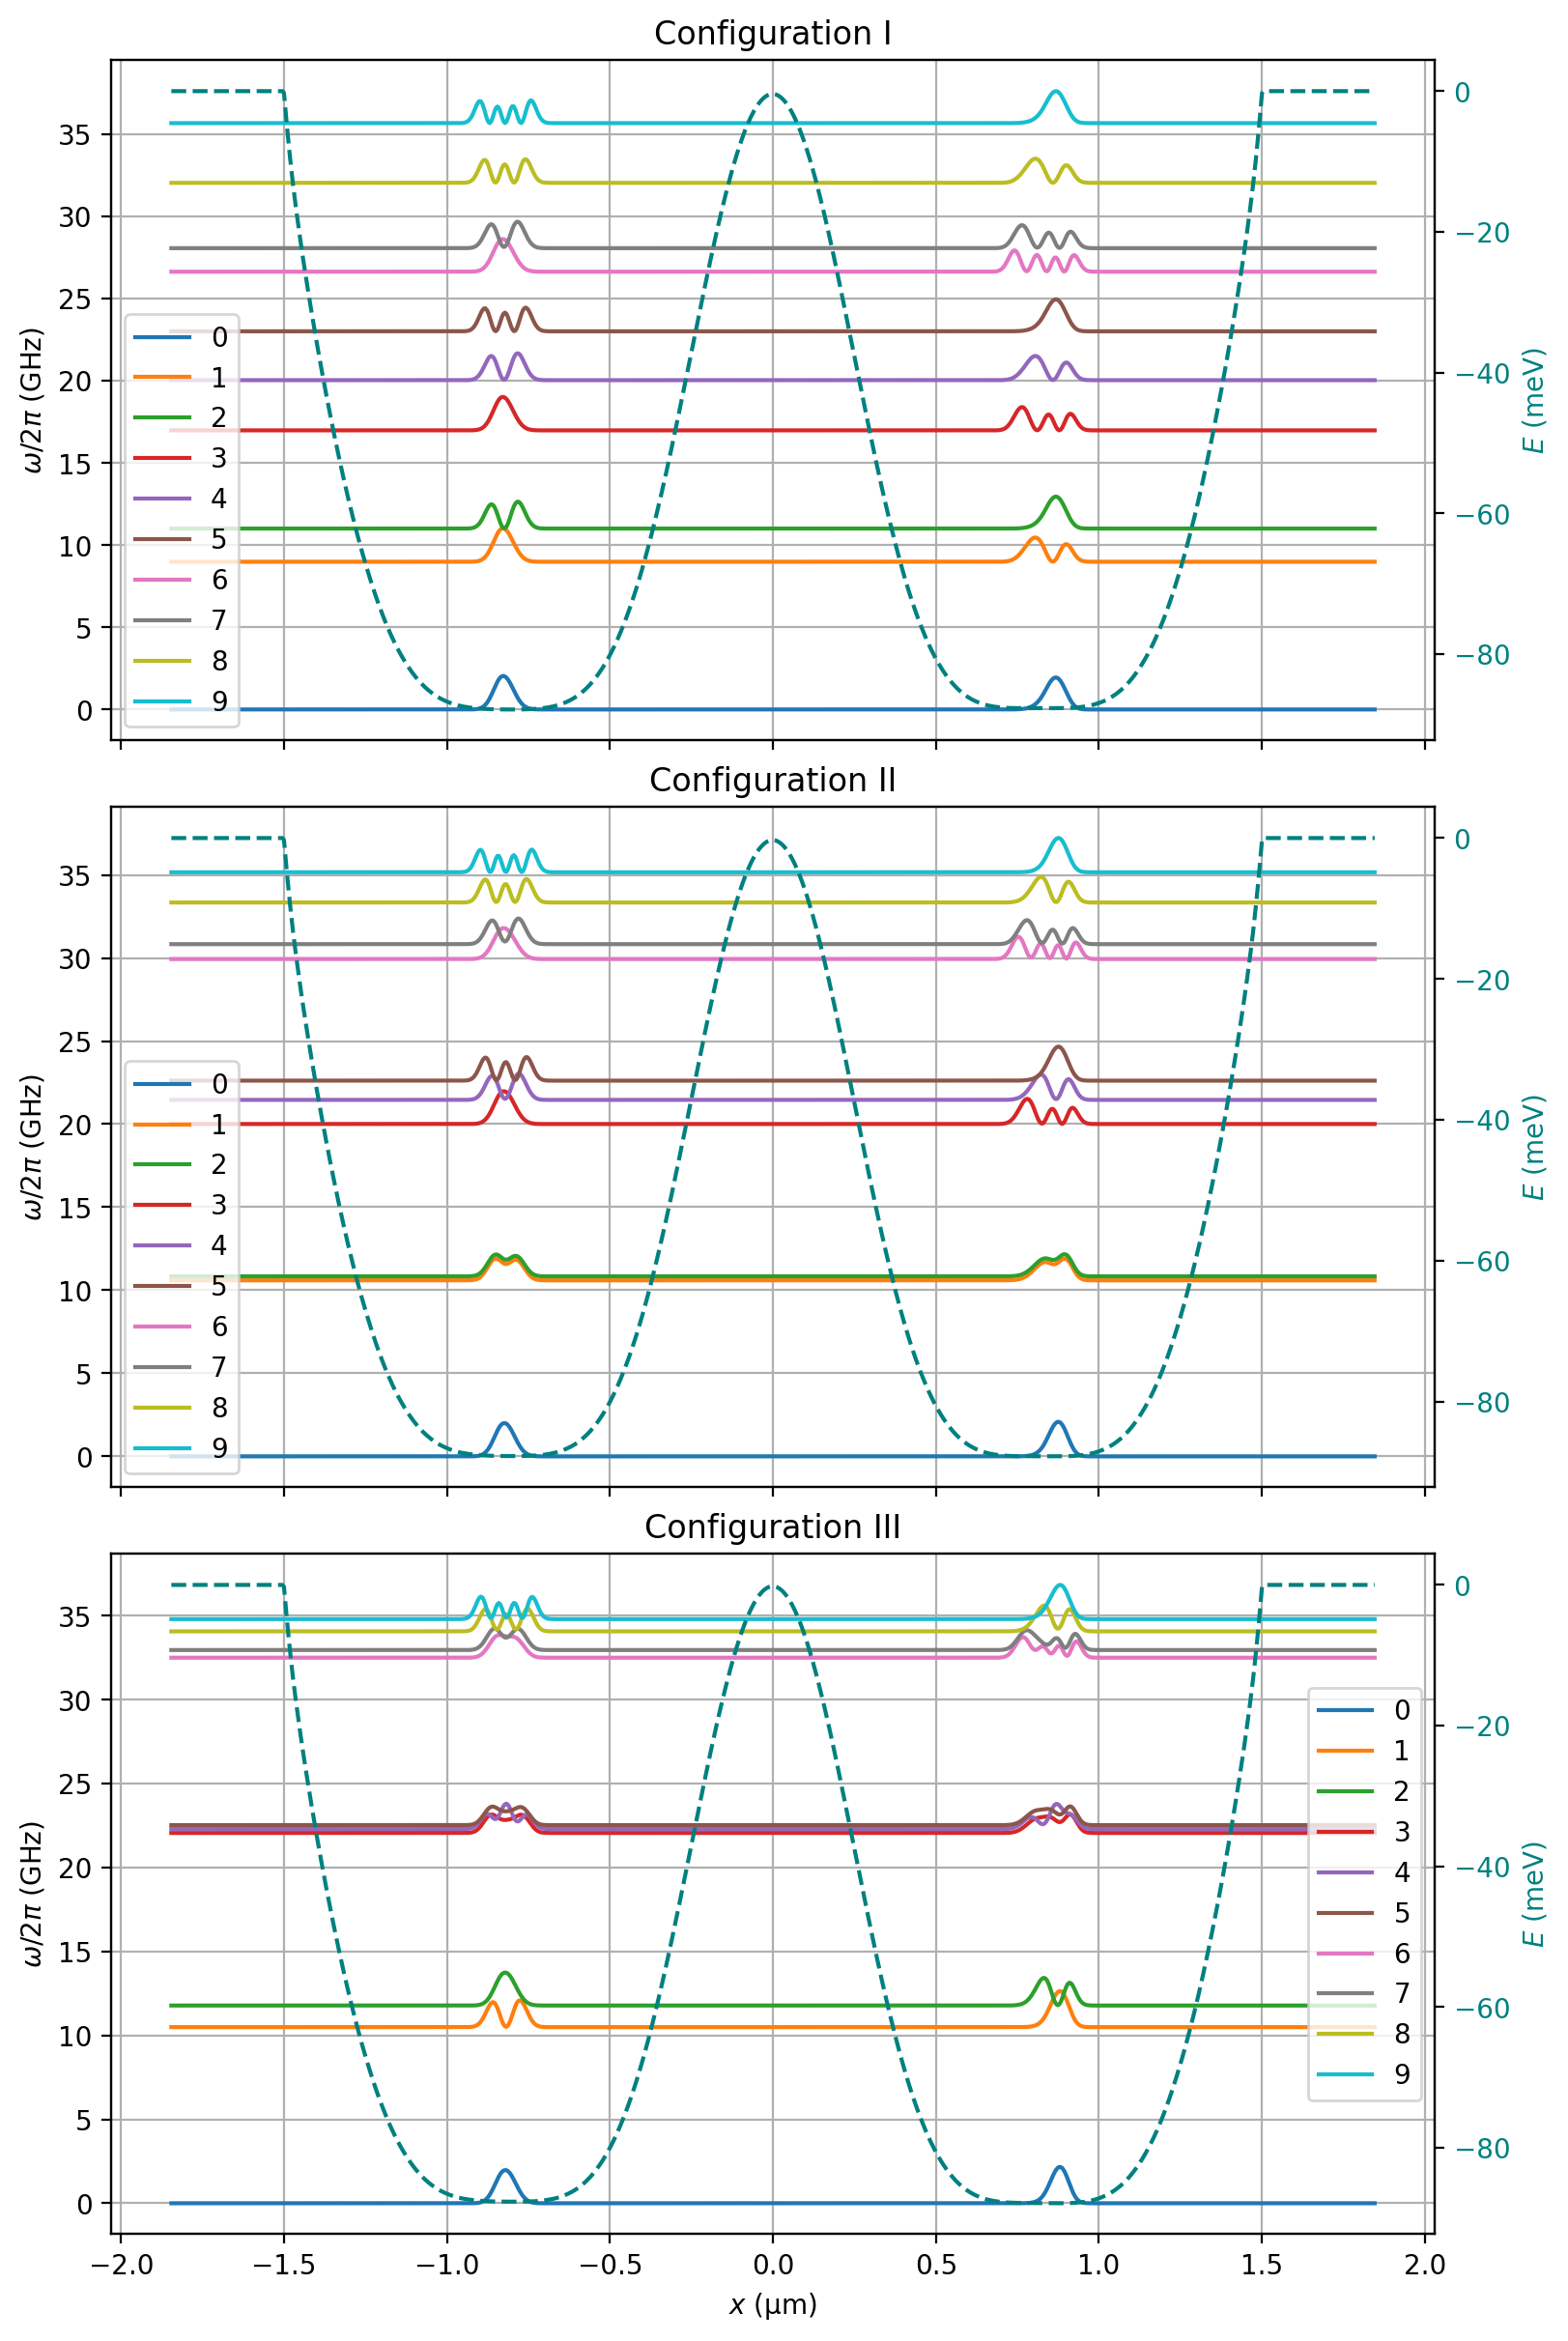

In [24]:
fig, axs = plt.subplots(
    nrows=3, ncols=1, sharex=True, layout="constrained", figsize=(8, 12)
)


num_plots = min(lhsds.num_two_body_eigenstates, 10)

lhsds = configs["I"]
for i in range(num_plots):
    axs[0].plot(
        lhsds.x * length.to(ureg.micrometer).magnitude,
        (lhsds.particle_densities[i] + lhsds.trans_energies[i])
        * energy_frequency.to(ureg.GHz).magnitude,
        label=f"{i}",
    )

axs[0].set_title("Configuration I")
pot_ax = axs[0].twinx()
pot_ax.plot(
    lhsds.x * length.to(ureg.micrometer).magnitude,
    lhsds.potential(lhsds.x) * epsilon.to(ureg.millieV).magnitude,
    linestyle="--",
    color="teal",
)
pot_ax.set_ylabel(r"$E$ (meV)", color="teal")
pot_ax.tick_params(axis="y", labelcolor="teal")

lhsds = configs["II"]
for i in range(num_plots):
    axs[1].plot(
        lhsds.x * length.to(ureg.micrometer).magnitude,
        (lhsds.particle_densities[i] + lhsds.trans_energies[i])
        * energy_frequency.to(ureg.GHz).magnitude,
        label=f"{i}",
    )

axs[1].set_title("Configuration II")
pot_ax = axs[1].twinx()
pot_ax.plot(
    lhsds.x * length.to(ureg.micrometer).magnitude,
    lhsds.potential(lhsds.x) * epsilon.to(ureg.millieV).magnitude,
    linestyle="--",
    color="teal",
)
pot_ax.set_ylabel(r"$E$ (meV)", color="teal")
pot_ax.tick_params(axis="y", labelcolor="teal")


lhsds = configs["III"]
for i in range(num_plots):
    axs[2].plot(
        lhsds.x * length.to(ureg.micrometer).magnitude,
        (lhsds.particle_densities[i] + lhsds.trans_energies[i])
        * energy_frequency.to(ureg.GHz).magnitude,
        label=f"{i}",
    )

axs[2].set_title("Configuration III")
pot_ax = axs[2].twinx()
pot_ax.plot(
    lhsds.x * length.to(ureg.micrometer).magnitude,
    lhsds.potential(lhsds.x) * epsilon.to(ureg.millieV).magnitude,
    linestyle="--",
    color="teal",
)
pot_ax.set_ylabel(r"$E$ (meV)", color="teal")
pot_ax.tick_params(axis="y", labelcolor="teal")


for i in range(len(axs)):
    axs[i].grid()
    axs[i].set_ylabel(r"$\omega / 2 \pi$ (GHz)")
    axs[i].legend()

axs[2].set_xlabel(r"$x$ ($\mathrm{\mu}$m)")
plt.show()

Save the densities and the potentials for each configuration.

In [25]:
if SAVEFIGS:
    for config, lhsds in configs.items():
        dir_path = os.path.join("dat", f"densities_{config}")
        try:
            os.mkdir(dir_path)
        except FileExistsError:
            pass

        print(
            f"{config:3}:",
            f"a_l = {lhsds.anharmonicity_l * energy_frequency.to(ureg.GHz):.2f},",
            f"a_r = {lhsds.anharmonicity_r * energy_frequency.to(ureg.GHz):.2f}",
        )

        np.savetxt(
            os.path.join(dir_path, "potential.txt"),
            np.concatenate(
                [
                    lhsds.x[:, None] * length.to(ureg.micrometer).magnitude,
                    lhsds.potential(lhsds.x)[:, None]
                    * epsilon.to(ureg.millieV).magnitude,
                ],
                axis=1,
            ),
            header="x [um] | potential [millieV]",
        )

        for i in range(num_plots):
            np.savetxt(
                os.path.join(dir_path, f"rho_{i}.txt"),
                np.concatenate(
                    [
                        lhsds.x[:, None] * length.to(ureg.micrometer).magnitude,
                        (lhsds.particle_densities[i] + lhsds.trans_energies[i])[:, None]
                        * energy_frequency.to(ureg.GHz).magnitude,
                    ],
                    axis=1,
                ),
                header="x [um] | rho + eps [millieV]",
            )

I  : a_l = 1.00 gigahertz, a_r = -1.00 gigahertz
II : a_l = 1.16 gigahertz, a_r = -1.40 gigahertz
III: a_l = 1.28 gigahertz, a_r = -1.24 gigahertz


In [26]:
print(
    f"{(configs['I'].trans_energies[4] - configs['I'].trans_energies[1]) * energy_frequency.to(ureg.GHz):.2f}"
)

11.05 gigahertz


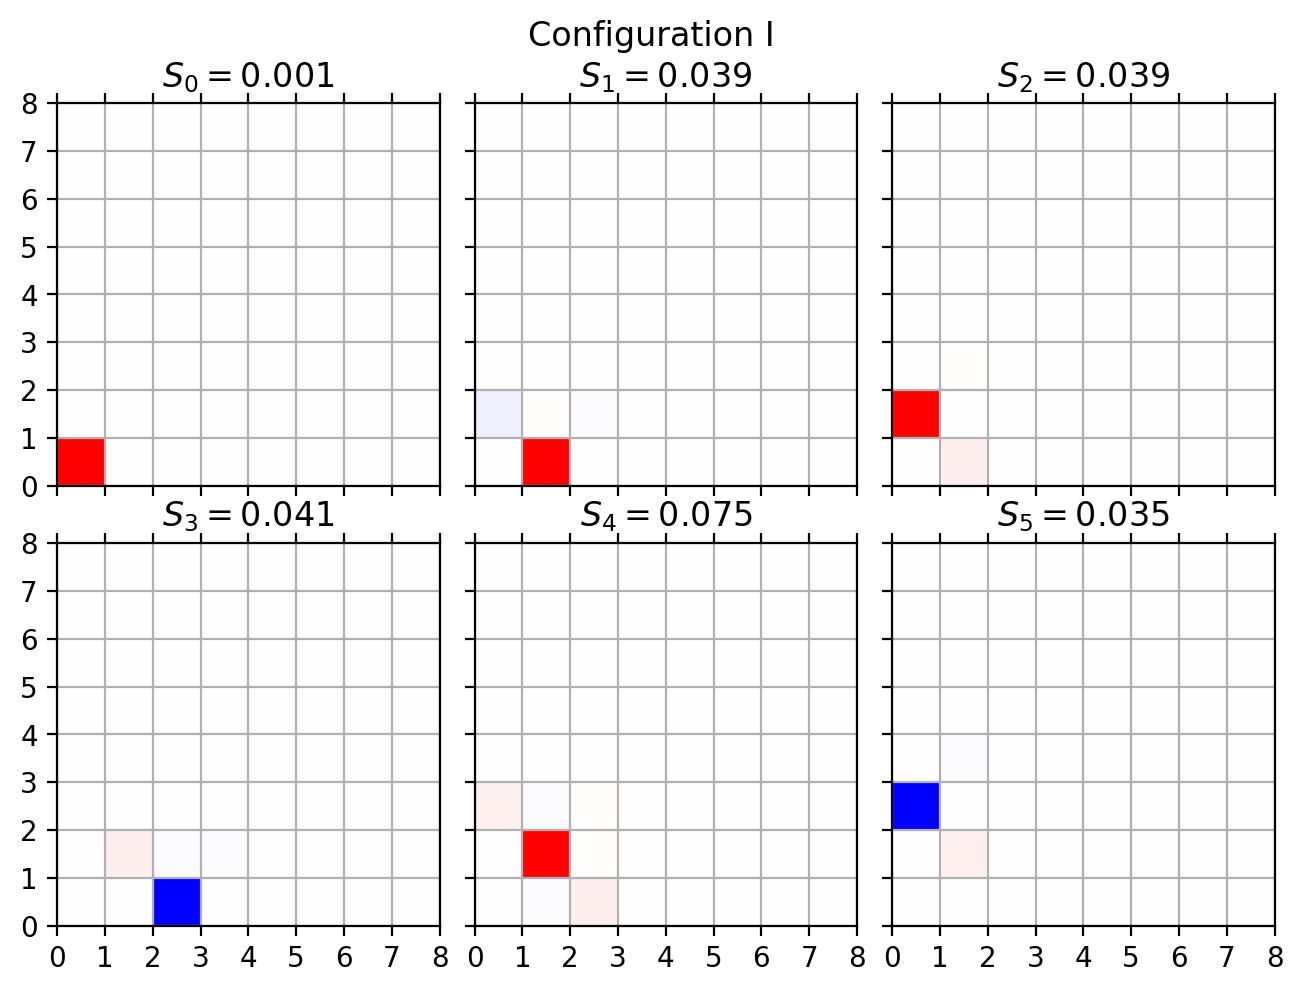

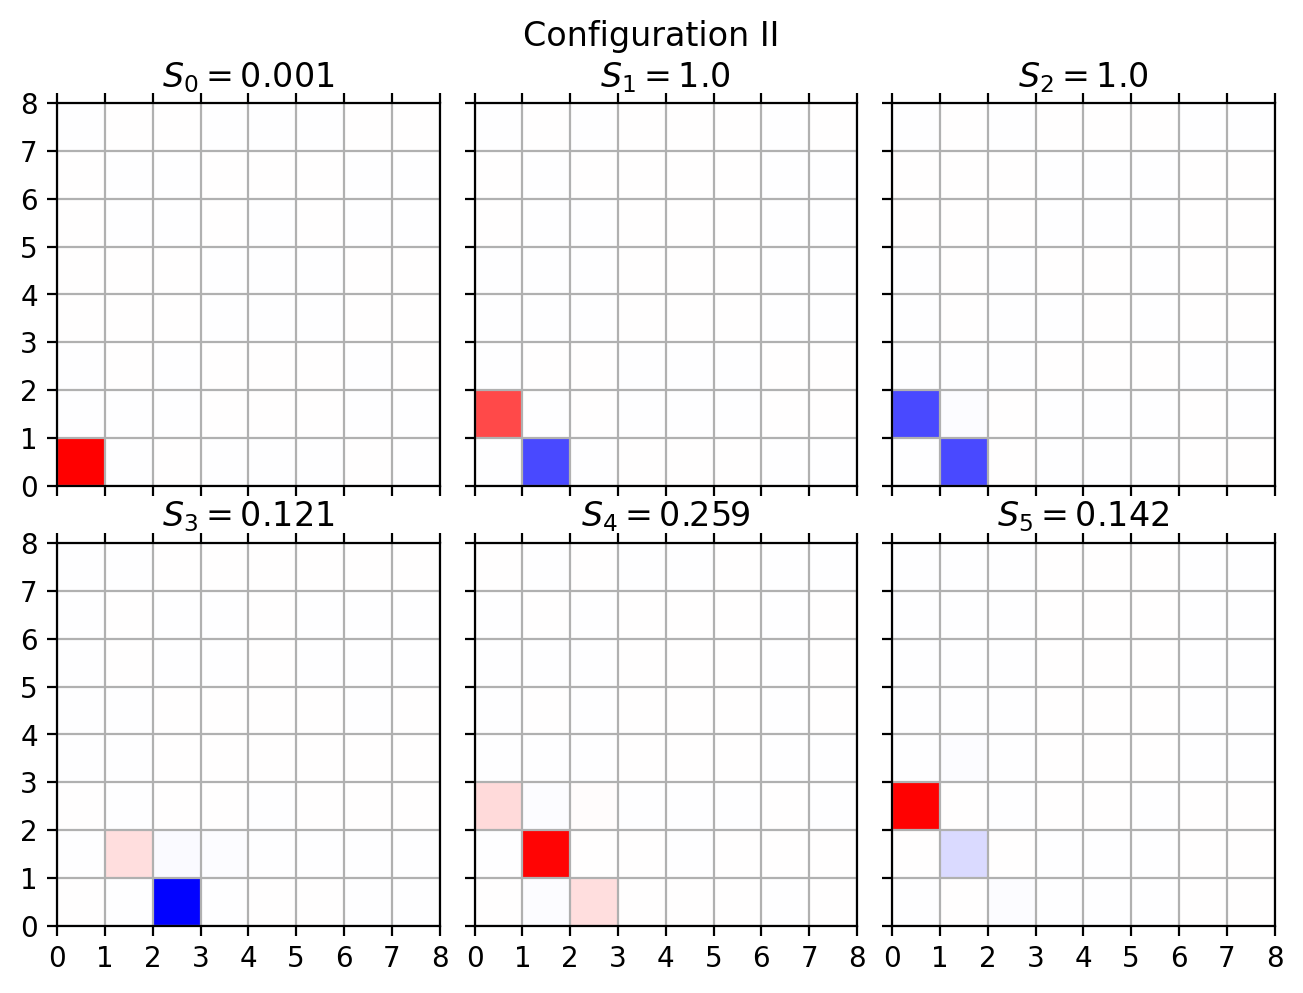

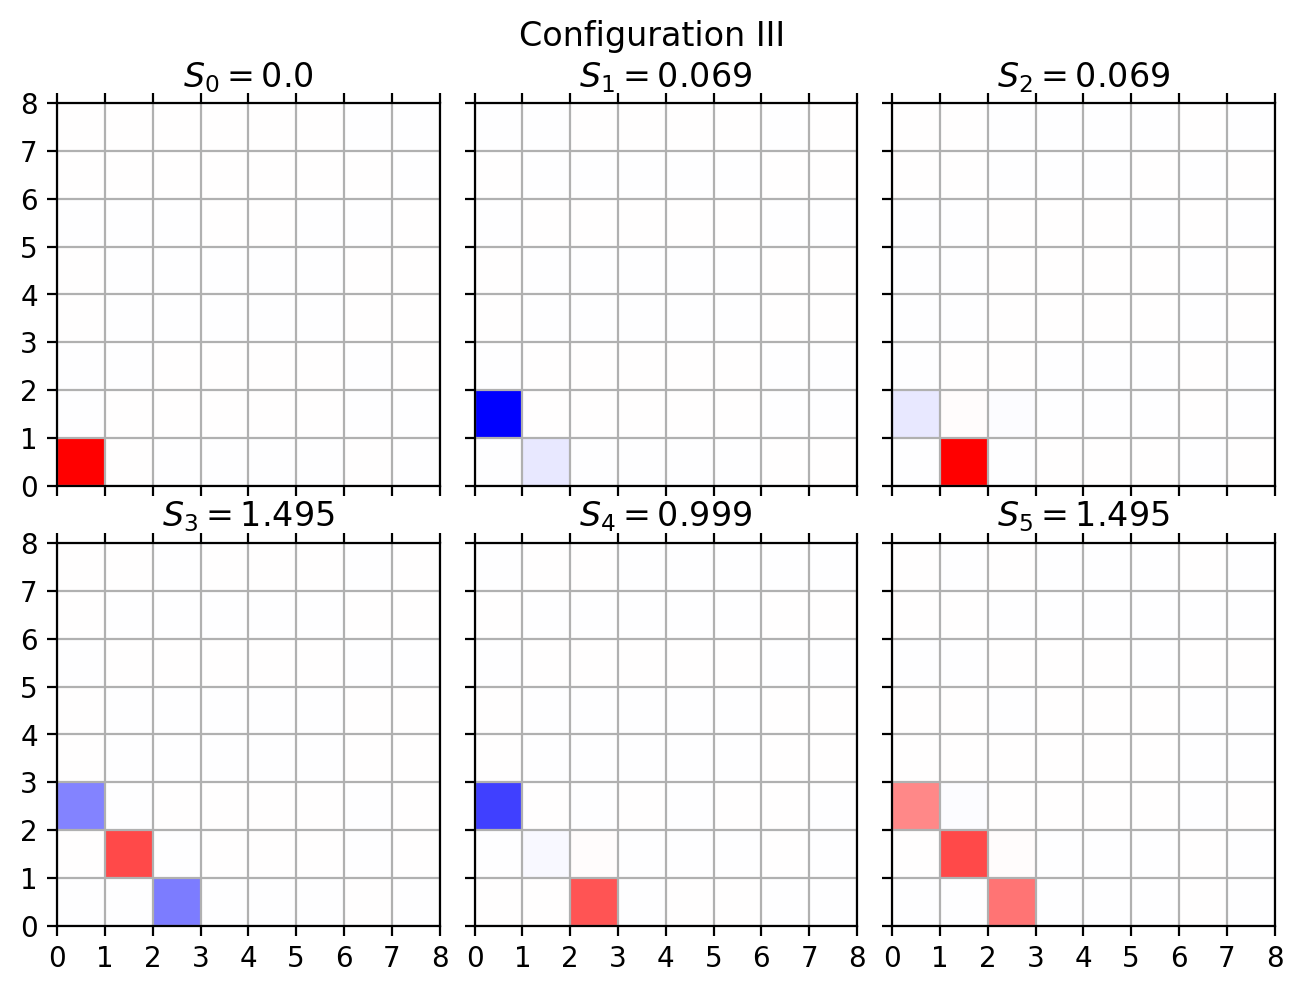

In [27]:
fig, axs = plt.subplots(
    nrows=2, ncols=3, layout="constrained", sharey="row", sharex="col"
)

lhsds = configs["I"]
for i in range(2):
    for j in range(3):
        axs[i, j].matshow(
            lhsds.energy_coefficients[i * 3 + j],
            extent=[
                0,
                min(lhsds.num_basis_l, lhsds.num_basis_r),
                0,
                min(lhsds.num_basis_l, lhsds.num_basis_r),
            ],
            vmin=-1,
            vmax=1,
            cmap="bwr",
            origin="lower",
        )
        axs[i, j].grid()
        axs[i, j].set_title(
            r"$S_{"
            + f"{i * 3 + j}"
            + r"} = "
            + f"{np.round(lhsds.entropies[i * 3 + j], 3)}$"
        )

for j in range(3):
    axs[1, j].tick_params(labelbottom=True, labeltop=False)

plt.suptitle("Configuration I")
plt.show()


fig, axs = plt.subplots(
    nrows=2, ncols=3, layout="constrained", sharey="row", sharex="col"
)

lhsds = configs["II"]
for i in range(2):
    for j in range(3):
        axs[i, j].matshow(
            lhsds.energy_coefficients[i * 3 + j],
            extent=[
                0,
                min(lhsds.num_basis_l, lhsds.num_basis_r),
                0,
                min(lhsds.num_basis_l, lhsds.num_basis_r),
            ],
            vmin=-1,
            vmax=1,
            cmap="bwr",
            origin="lower",
        )
        axs[i, j].grid()
        axs[i, j].set_title(
            r"$S_{"
            + f"{i * 3 + j}"
            + r"} = "
            + f"{np.round(lhsds.entropies[i * 3 + j], 3)}$"
        )

for j in range(3):
    axs[1, j].tick_params(labelbottom=True, labeltop=False)

plt.suptitle("Configuration II")
plt.show()


fig, axs = plt.subplots(
    nrows=2, ncols=3, layout="constrained", sharey="row", sharex="col"
)

lhsds = configs["III"]
for i in range(2):
    for j in range(3):
        axs[i, j].matshow(
            lhsds.energy_coefficients[i * 3 + j],
            extent=[
                0,
                min(lhsds.num_basis_l, lhsds.num_basis_r),
                0,
                min(lhsds.num_basis_l, lhsds.num_basis_r),
            ],
            vmin=-1,
            vmax=1,
            cmap="bwr",
            origin="lower",
        )
        axs[i, j].grid()
        axs[i, j].set_title(
            r"$S_{"
            + f"{i * 3 + j}"
            + r"} = "
            + f"{np.round(lhsds.entropies[i * 3 + j], 3)}$"
        )

for j in range(3):
    axs[1, j].tick_params(labelbottom=True, labeltop=False)

plt.suptitle("Configuration III")
plt.show()

Save the coefficients for each configuration.

In [28]:
if SAVEFIGS:
    for config, lhsds in configs.items():
        dir_path = os.path.join("dat", f"coefficients_{config}")
        try:
            os.mkdir(dir_path)
        except FileExistsError:
            pass

        for i in range(6):
            C = lhsds.energy_coefficients[i]
            with open(os.path.join(dir_path, f"C_{i}.txt"), "w") as f:
                for ind in np.ndindex(C.shape):
                    f.write(f"{ind[0]} {ind[1]} {C[ind]}\n")

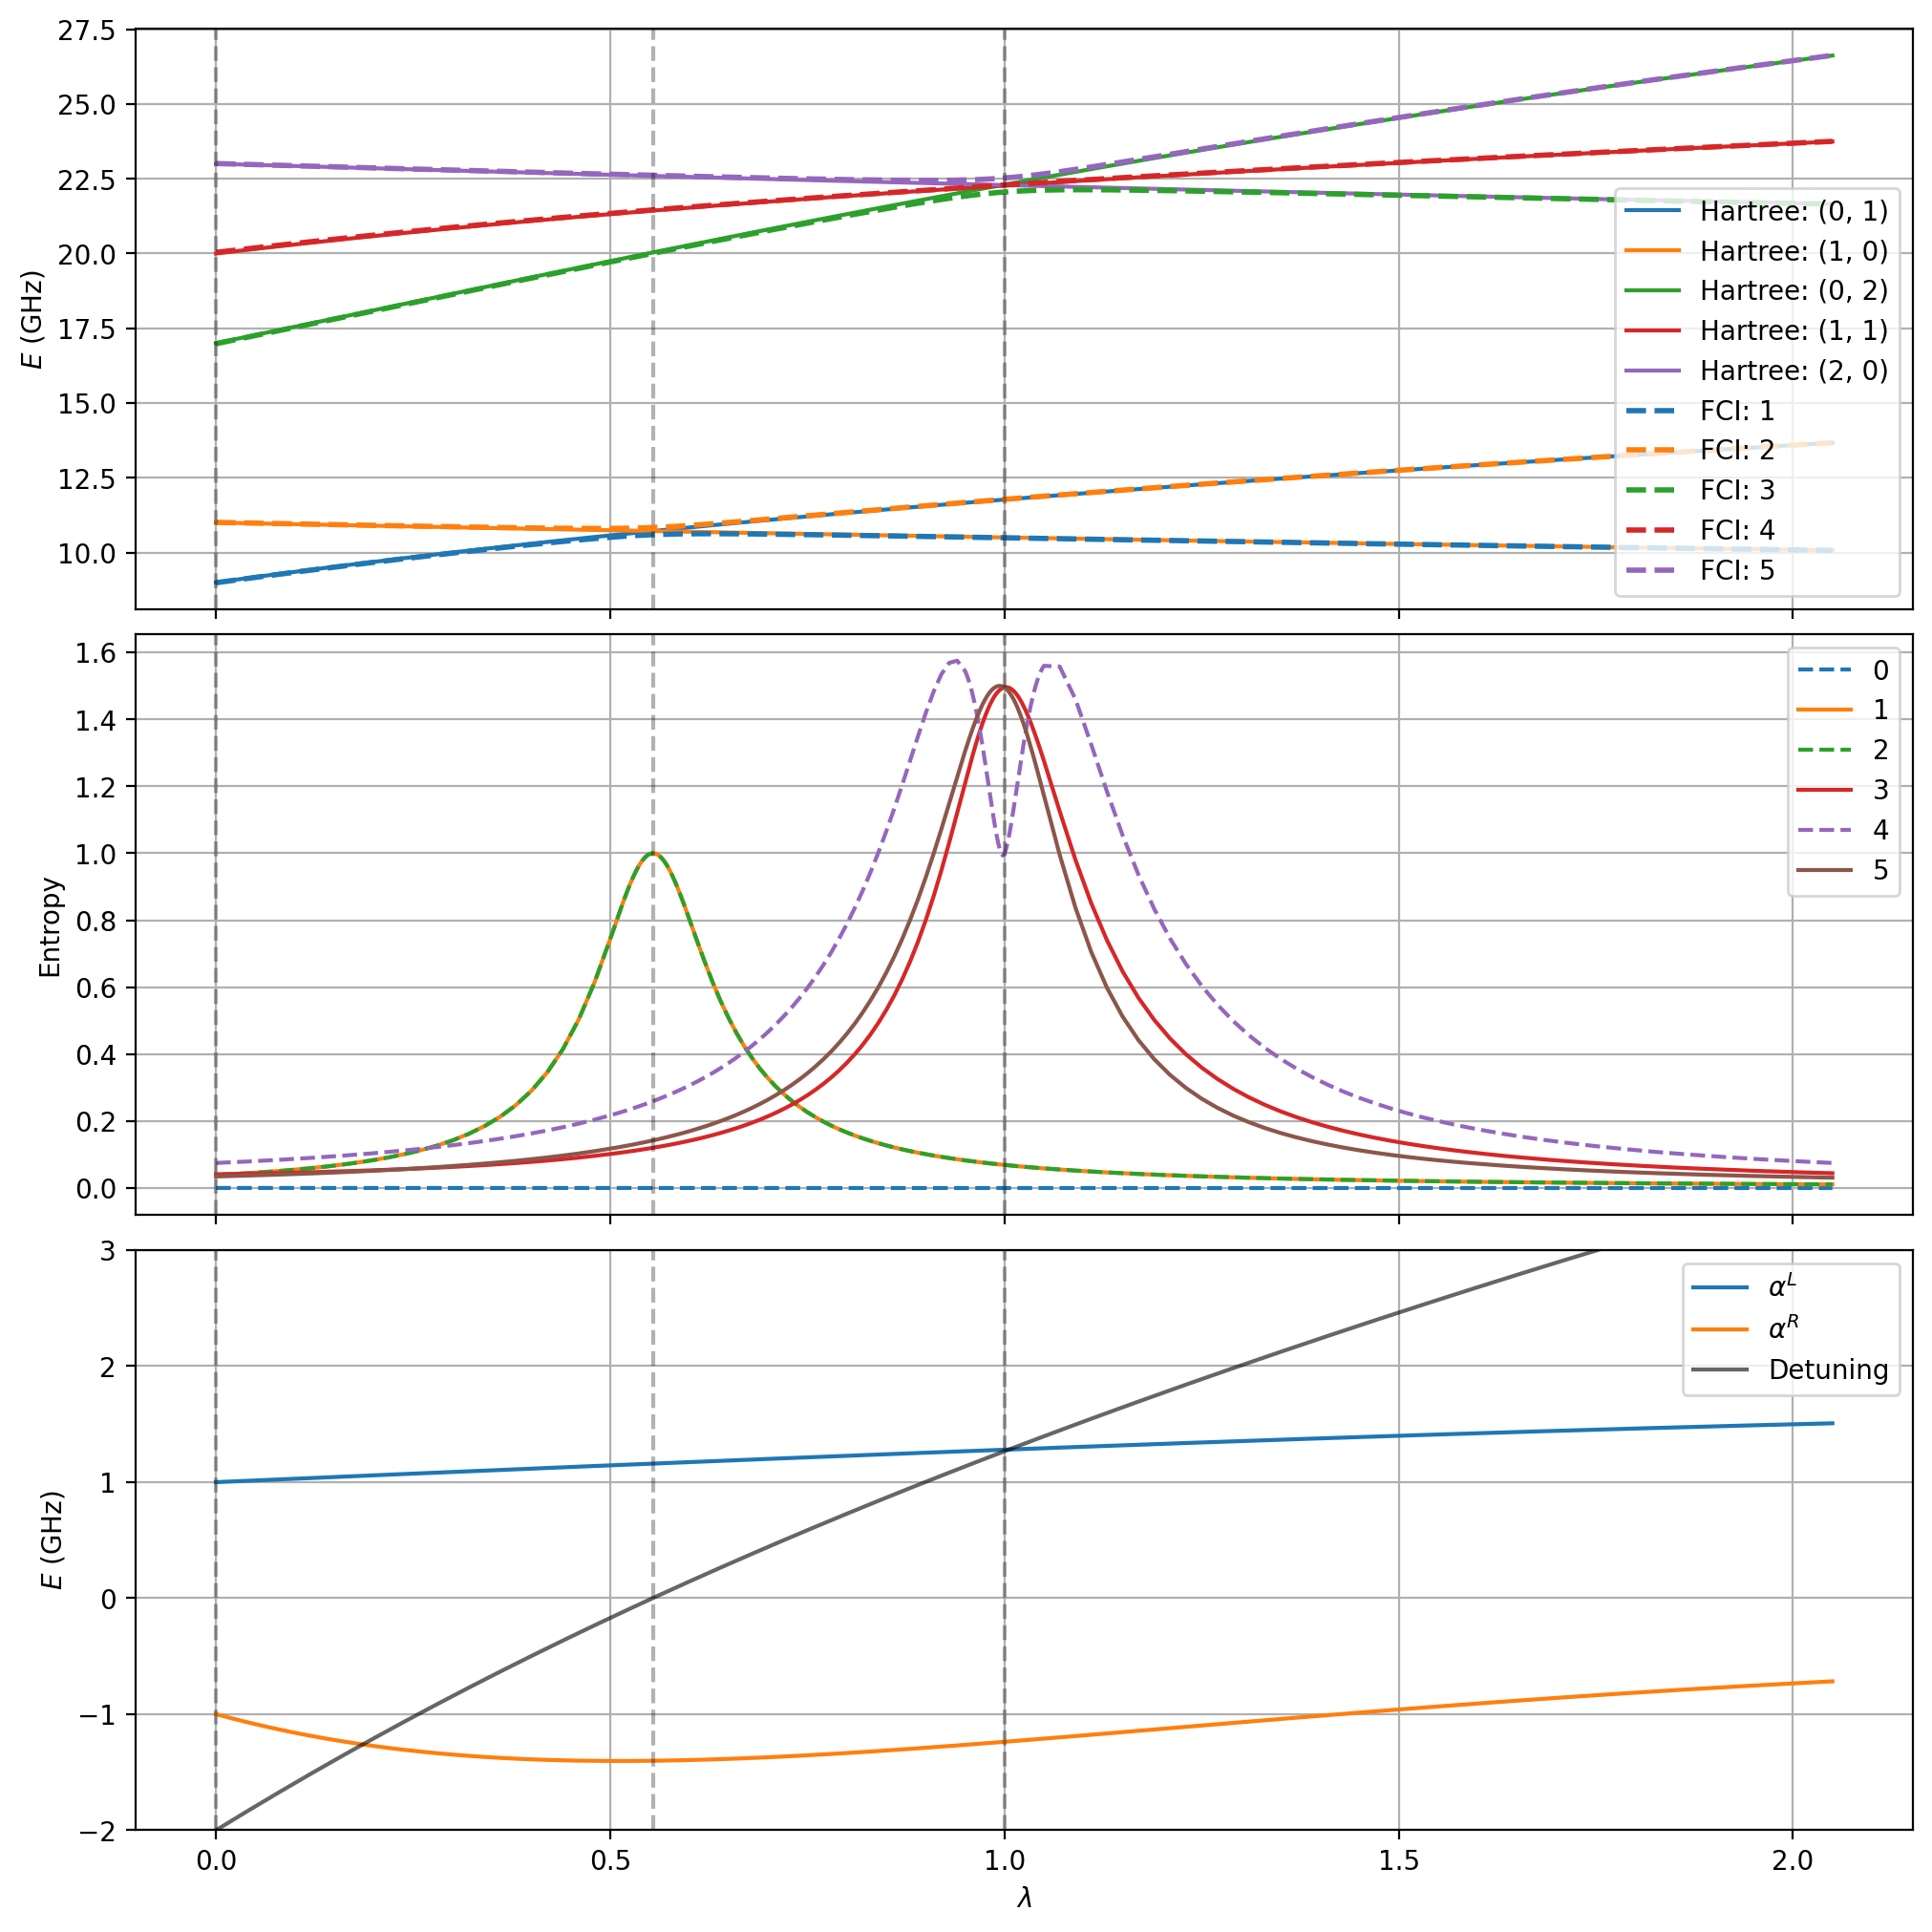

In [29]:
fig, axs = plt.subplots(
    nrows=3, ncols=1, layout="constrained", sharex=True, figsize=(10, 10)
)

cmap = plt.get_cmap("tab10")


for k, (i, j) in enumerate(
    [(0, 1), (1, 0), (0, 2), (1, 1), (2, 0)]  # , (2, 1), (1, 2), (0, 3), (3, 0)]
):
    axs[0].plot(
        sorted(lhsds_dict),
        [
            (
                lhsds_dict[key].non_int_trans_energies[(i, j)]
                * energy_frequency.to(ureg.GHz).magnitude
            )
            for key in sorted(lhsds_dict)
        ],
        color=cmap(k),
        label=f"Hartree: {(i, j)}",
    )

# for i in range(1, lhsds_dict[0].num_two_body_eigenstates):
for i in range(1, min(lhsds_dict[0].num_two_body_eigenstates, 6)):
    axs[0].plot(
        sorted(lhsds_dict),
        [
            (
                lhsds_dict[key].trans_energies[i]
                * energy_frequency.to(ureg.GHz).magnitude
            )
            for key in sorted(lhsds_dict)
        ],
        "--",
        lw=2,
        color=cmap(i - 1),
        label=f"FCI: {i}",
    )

for i in range(min(6, num_two_body_eigenstates)):
    axs[1].plot(
        sorted(lhsds_dict),
        [lhsds_dict[key].entropies[i] for key in sorted(lhsds_dict)],
        "--" if i % 2 == 0 else "-",
        label=f"{i}",
    )

axs[2].plot(
    sorted(lhsds_dict),
    [
        lhsds_dict[key].anharmonicity_l * energy_frequency.to(ureg.GHz).magnitude
        for key in sorted(lhsds_dict)
    ],
    label=r"$\alpha^L$",
)
axs[2].plot(
    sorted(lhsds_dict),
    [
        lhsds_dict[key].anharmonicity_r * energy_frequency.to(ureg.GHz).magnitude
        for key in sorted(lhsds_dict)
    ],
    label=r"$\alpha^R$",
)
axs[2].plot(
    sorted(lhsds_dict),
    [
        (
            -(lhsds_dict[key].eps_l[1] - lhsds_dict[key].eps_l[0])
            + (lhsds_dict[key].eps_r[1] - lhsds_dict[key].eps_r[0])
        )
        * energy_frequency.to(ureg.GHz).magnitude
        for key in sorted(lhsds_dict)
    ],
    label="Detuning",
    color="black",
    alpha=0.6,
)

for i in range(len(axs)):
    axs[i].grid()
    axs[i].legend()
    axs[i].axvline(configs["I"].c_lambda, ls="--", color="black", alpha=0.3)
    axs[i].axvline(configs["II"].c_lambda, ls="--", color="black", alpha=0.3)
    axs[i].axvline(configs["III"].c_lambda, ls="--", color="black", alpha=0.3)

axs[0].set_ylabel(f"$E$ (GHz)")
axs[1].set_ylabel(f"Entropy")
axs[2].set_ylabel(f"$E$ (GHz)")
axs[2].set_xlabel(f"$\lambda$")
axs[2].set_ylim([-2, 3])

plt.show()

In [47]:
f01 = np.asarray([(lhsds_dict[key].non_int_trans_energies[(0, 1)] * energy_frequency.to(ureg.GHz).magnitude) for key in sorted(lhsds_dict)])
f10 = np.asarray([(lhsds_dict[key].non_int_trans_energies[(1, 0)] * energy_frequency.to(ureg.GHz).magnitude) for key in sorted(lhsds_dict)])
f20 = np.asarray([(lhsds_dict[key].non_int_trans_energies[(2, 0)] * energy_frequency.to(ureg.GHz).magnitude) for key in sorted(lhsds_dict)])
f02 = np.asarray([(lhsds_dict[key].non_int_trans_energies[(0, 2)] * energy_frequency.to(ureg.GHz).magnitude) for key in sorted(lhsds_dict)])


anh01 = f02 - 2*f01
anh10 = f20 - 2*f10
Delta = f01 - f10

fi01 = np.asarray([(lhsds_dict[key].trans_energies[0] * energy_frequency.to(ureg.GHz).magnitude) for key in sorted(lhsds_dict)])
fi10 = np.asarray([(lhsds_dict[key].trans_energies[1] * energy_frequency.to(ureg.GHz).magnitude) for key in sorted(lhsds_dict)])

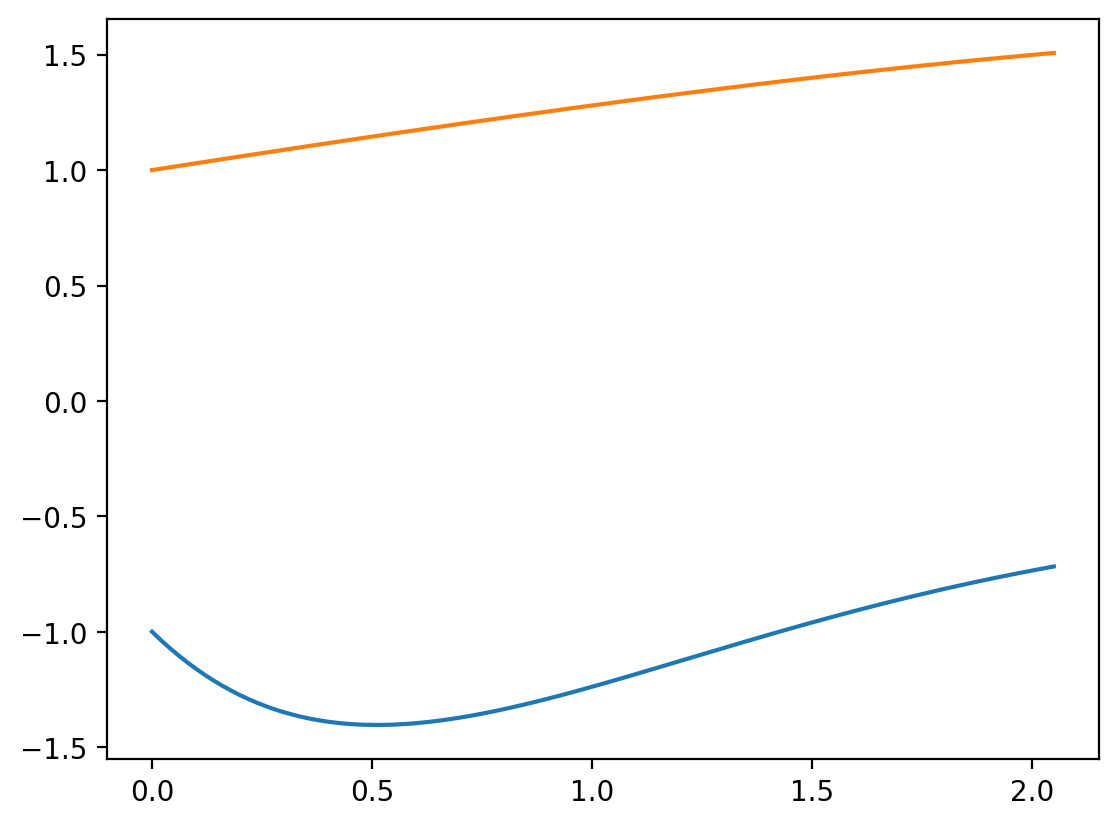

In [48]:
plt.plot(sorted(lhsds_dict), anh01)
plt.plot(sorted(lhsds_dict), anh10)
#plt.yscale('log')
plt.show()

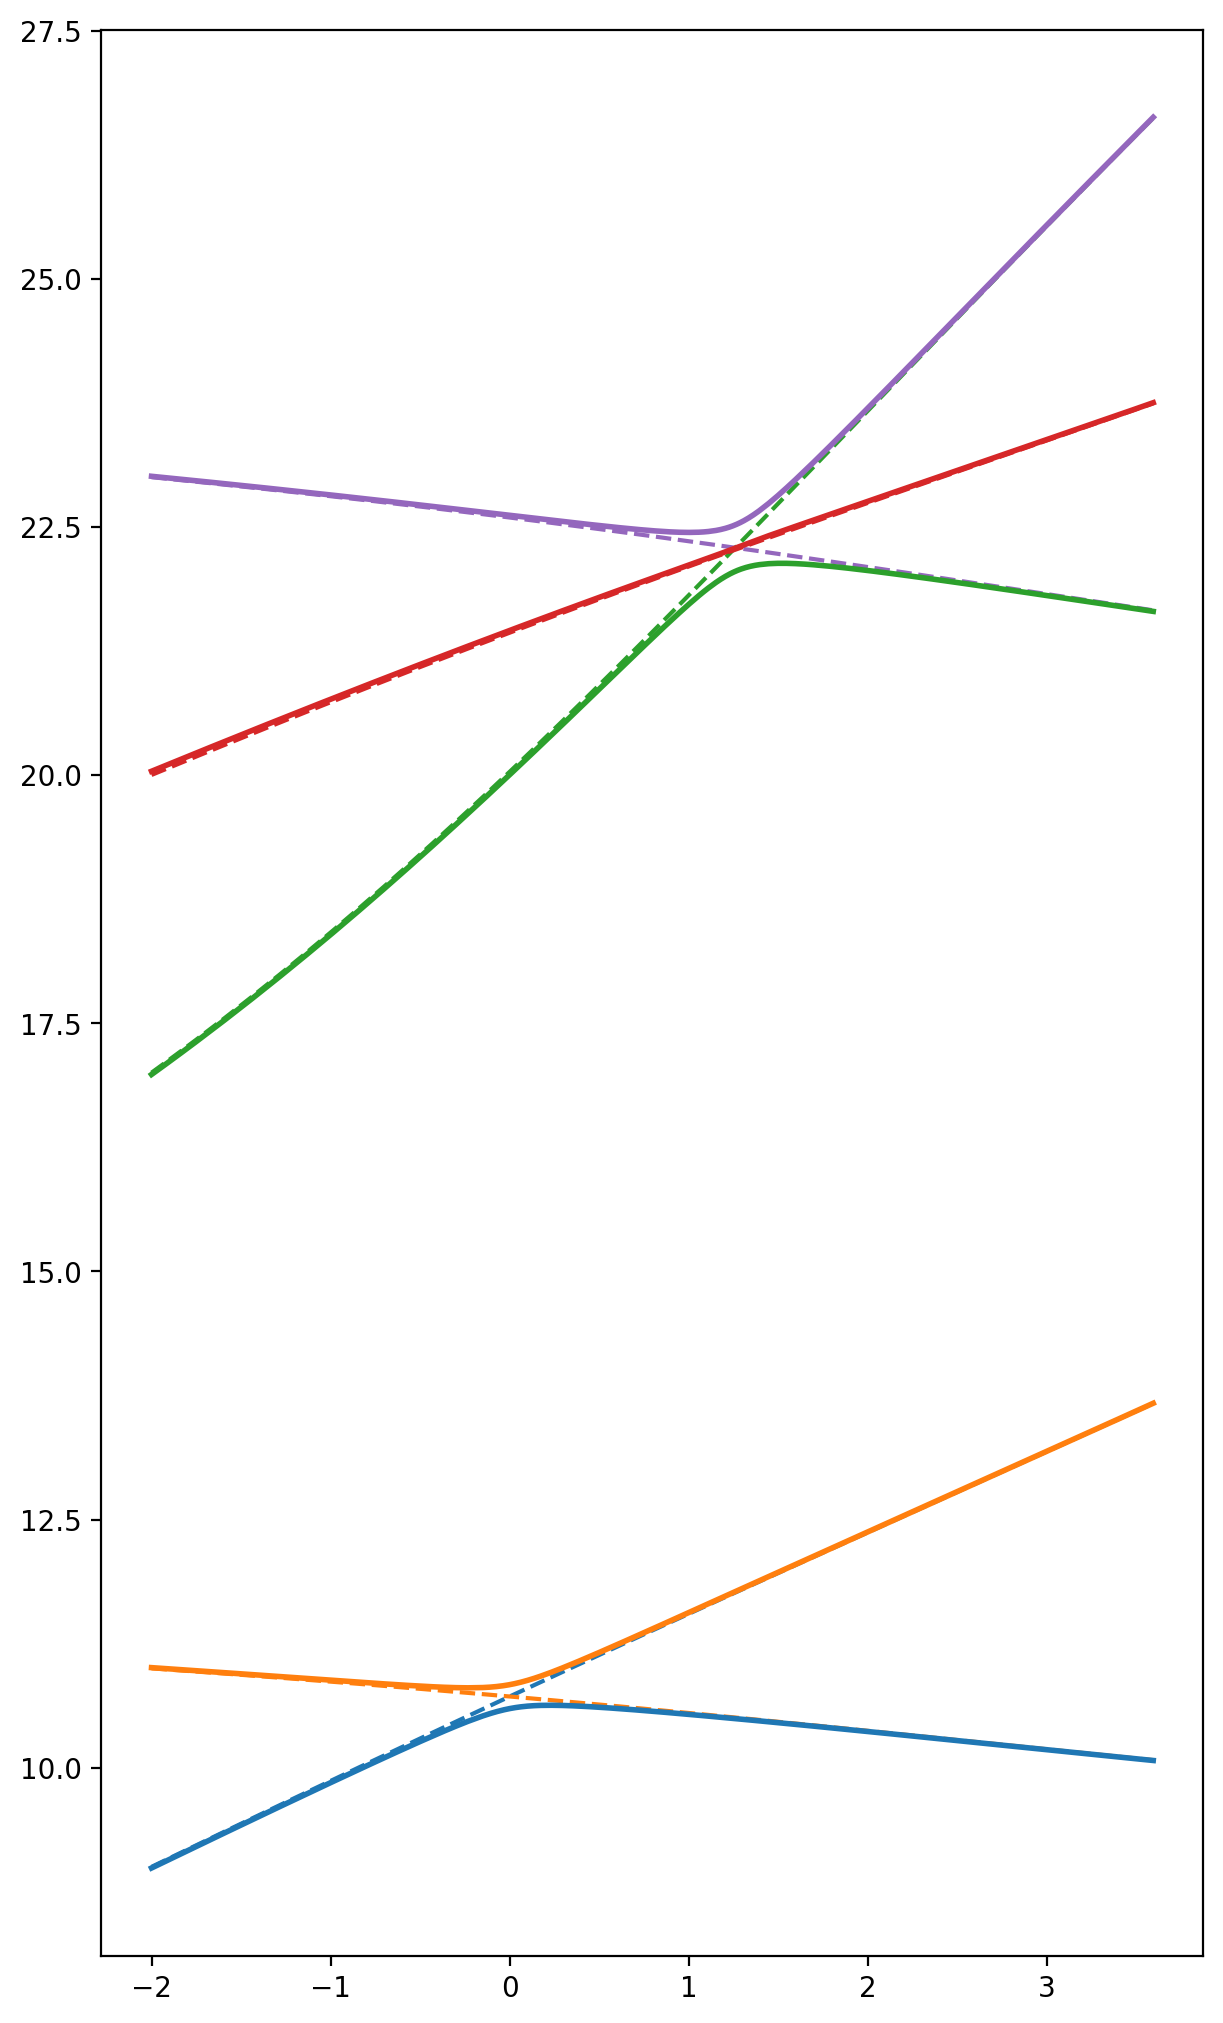

In [32]:
fig, axs = plt.subplots(
    nrows=1, ncols=1, layout="constrained", sharex=True, figsize=(6, 10)
)

cmap = plt.get_cmap("tab10")


for k, (i, j) in enumerate(
    [(0, 1), (1, 0), (0, 2), (1, 1), (2, 0)]  # , (2, 1), (1, 2), (0, 3), (3, 0)]
):
    axs.plot(
        f01 - f10,
        [(lhsds_dict[key].non_int_trans_energies[(i, j)] * energy_frequency.to(ureg.GHz).magnitude) for key in sorted(lhsds_dict)],
        "--",
        color=cmap(k),
        label=f"Hartree: {(i, j)}",
    )

for i in range(1, min(lhsds_dict[0].num_two_body_eigenstates, 6)):
    axs.plot(
        f01 - f10,
        [(lhsds_dict[key].trans_energies[i] * energy_frequency.to(ureg.GHz).magnitude) for key in sorted(lhsds_dict)],
        "-",
        lw=2,
        color=cmap(i - 1),
        label=f"FCI: {i}",
    )

plt.show()

In [34]:
from qutip import (Qobj, about, basis, coherent, coherent_dm, create, destroy,
                   expect, fock, fock_dm, mesolve, qeye, sigmax, sigmay,
                   sigmaz, tensor, thermal_dm)

In [78]:
# electron L and R operators
num_states = 6
a_L = tensor(destroy(num_states), qeye(num_states))
a_R = tensor(qeye(num_states), destroy(num_states))

# Hamiltonian of each qubit
H_L = lambda i: f01[i] * a_L.dag() * a_L + anh01[i] * a_L.dag() * a_L * (a_L.dag() * a_L - 1)/2
H_R = lambda i: f10[i] * a_R.dag() * a_R + anh10[i] * a_R.dag() * a_R * (a_R.dag() * a_R - 1)/2
H_i = lambda g: g * (a_R.dag() * a_L + a_L.dag() * a_R)

# total Hamiltonian
H = lambda i, g: H_L(i) + H_R(i) + H_i(g)

In [79]:
n = len(sorted(lhsds_dict))
spectrum = np.zeros((n, num_states**2))
for i in tqdm.tqdm(range(n)):
    spectrum[i] = H(i, 0.12).eigenenergies()

100%|██████████| 211/211 [00:00<00:00, 789.84it/s]


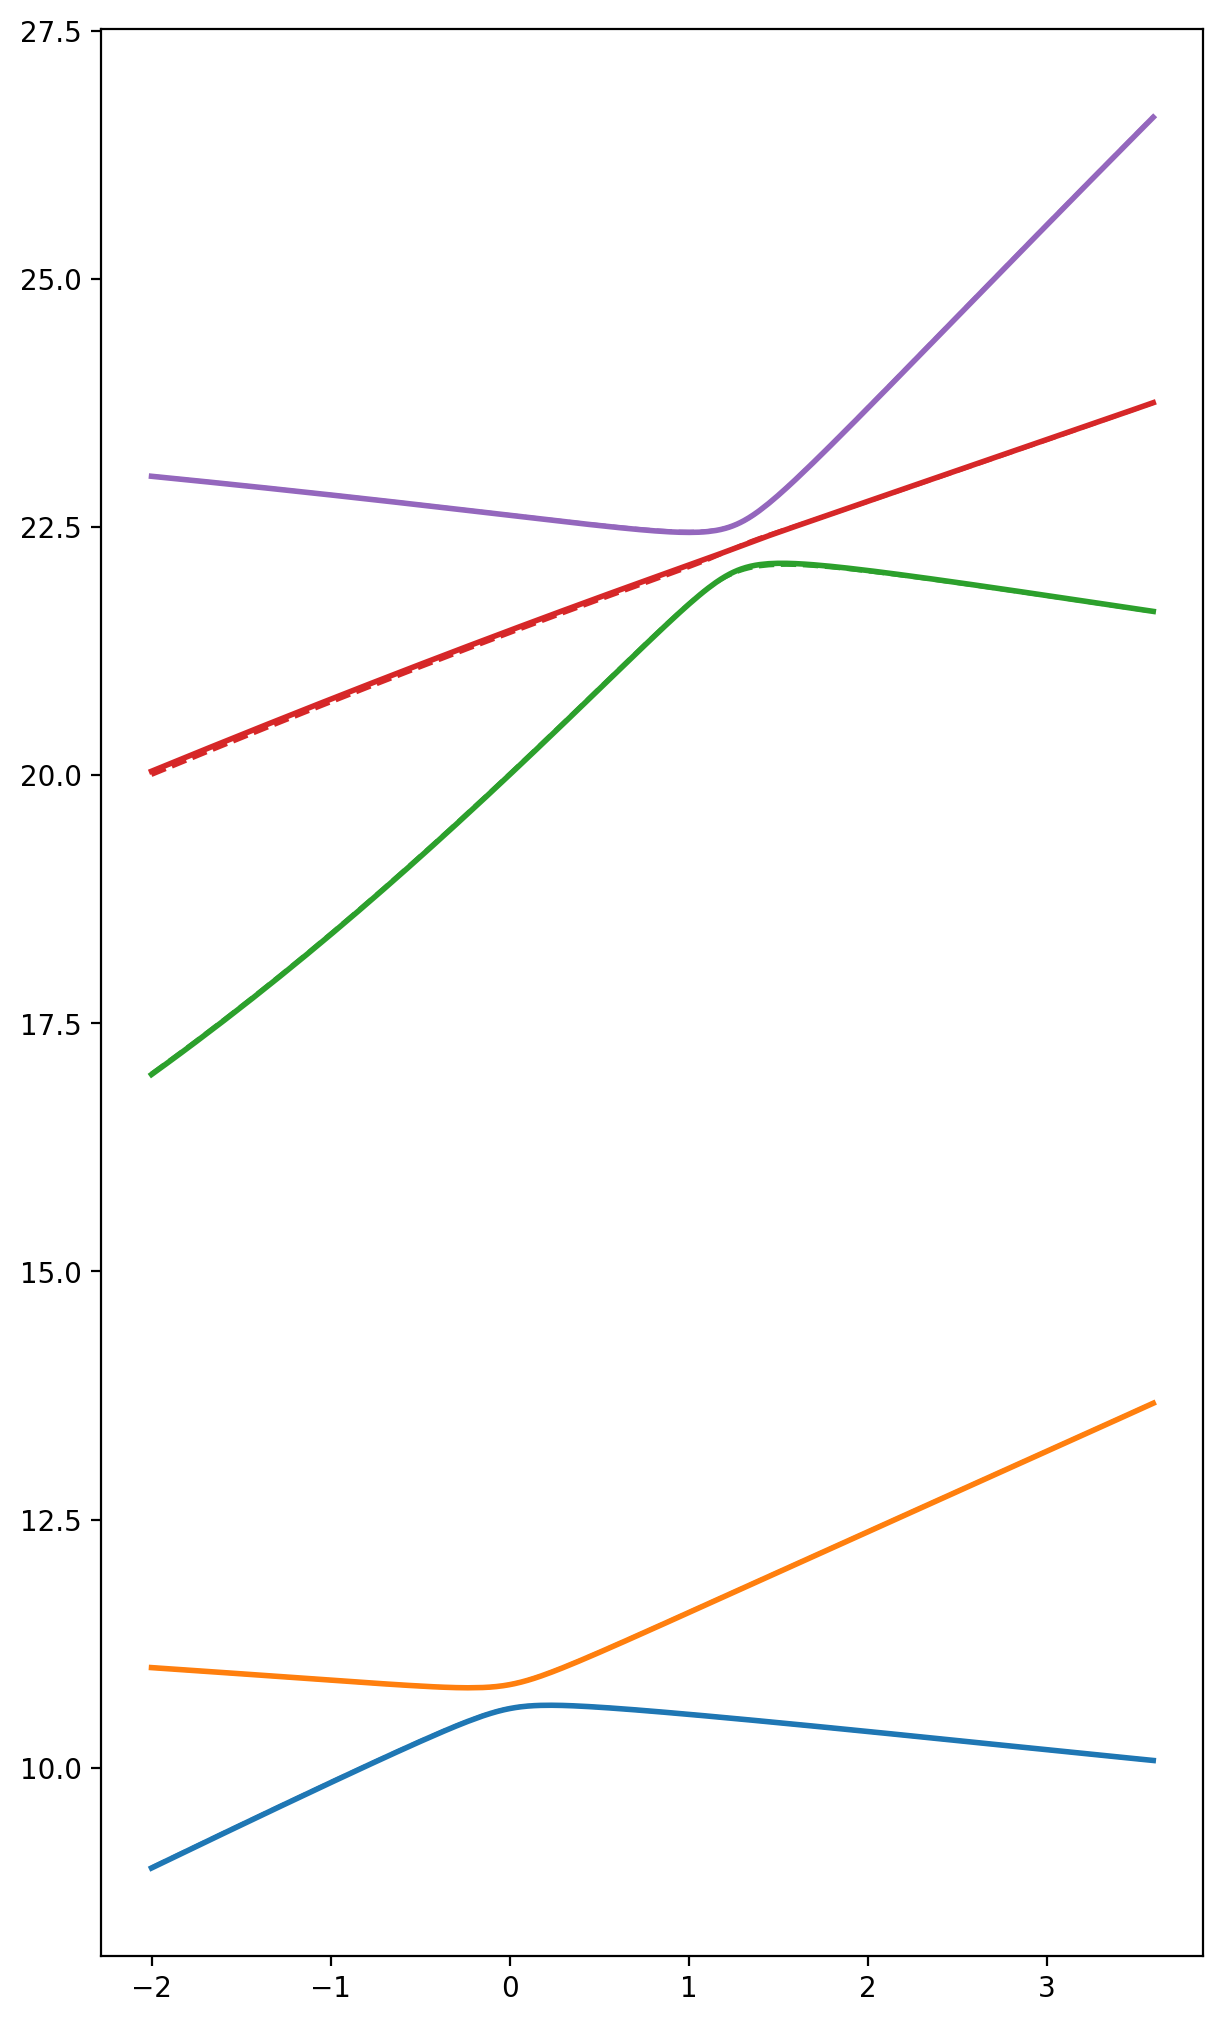

In [82]:
fig, axs = plt.subplots(
    nrows=1, ncols=1, layout="constrained", sharex=True, figsize=(6, 10)
)

cmap = plt.get_cmap("tab10")


for k in range(5):
    axs.plot(
        Delta,
        spectrum[:, k+1] - spectrum[:, 0] - 0.0,
        "--",
        color=cmap(k),
        label=f"num diag: {k}",
    )

for i in range(1, min(lhsds_dict[0].num_two_body_eigenstates, 6)):
    axs.plot(
        f01 - f10,
        [(lhsds_dict[key].trans_energies[i] * energy_frequency.to(ureg.GHz).magnitude) for key in sorted(lhsds_dict)],
        "-",
        lw=2,
        color=cmap(i - 1),
        label=f"FCI: {i}",
    )

plt.show()

In [33]:
np.argmax([lhsds_dict[key].entropies[1] for key in sorted(lhsds_dict)])

52

In [34]:
sorted(lhsds_dict)[55]

0.56

Save the energy spectrum as a function of the configurations.

In [35]:
if SAVEFIGS:
    dir_path = os.path.join("dat", f"crossings")
    try:
        os.mkdir(dir_path)
    except FileExistsError:
        pass

    sorted_keys = sorted(lhsds_dict)

    for i, j in [
        (0, 1),
        (1, 0),
        (2, 0),
        (1, 1),
        (0, 2),
        (3, 0),
        (2, 1),
        (1, 2),
        (0, 3),
    ]:
        np.savetxt(
            os.path.join(dir_path, f"E_hartree_{i}{j}.txt"),
            np.concatenate(
                [
                    np.array(sorted_keys)[:, None],
                    np.array(
                        [
                            (
                                lhsds_dict[key].non_int_trans_energies[(i, j)]
                                * energy_frequency.to(ureg.GHz).magnitude
                            )
                            for key in sorted_keys
                        ],
                    )[:, None],
                ],
                axis=1,
            ),
            header="lambda | energy [GHz]",
        )

    for i in range(1, 10):
        np.savetxt(
            os.path.join(dir_path, f"E_FCI_{i}.txt"),
            np.concatenate(
                [
                    np.array(sorted_keys)[:, None],
                    np.array(
                        [
                            (
                                lhsds_dict[key].trans_energies[i]
                                * energy_frequency.to(ureg.GHz).magnitude
                            )
                            for key in sorted_keys
                        ],
                    )[:, None],
                ],
                axis=1,
            ),
            header="lambda | energy [GHz]",
        )

Save the entropies as a function of the configurations.

In [36]:
if SAVEFIGS:
    dir_path = os.path.join("dat", f"entropies")
    try:
        os.mkdir(dir_path)
    except FileExistsError:
        pass

    sorted_keys = sorted(lhsds_dict)

    for i in range(10):
        np.savetxt(
            os.path.join(dir_path, f"S_{i}.txt"),
            np.concatenate(
                [
                    np.array(sorted_keys)[:, None],
                    np.array(
                        [(lhsds_dict[key].entropies[i]) for key in sorted_keys],
                    )[:, None],
                ],
                axis=1,
            ),
            header="lambda | entropy",
        )

Save the anharmonicites and the detuning as a function of the configurations.

In [37]:
if SAVEFIGS:
    dir_path = os.path.join("dat", f"anharmonicites")
    try:
        os.mkdir(dir_path)
    except FileExistsError:
        pass

    sorted_keys = sorted(lhsds_dict)

    np.savetxt(
        os.path.join(dir_path, "anharmonicity_l.txt"),
        np.concatenate(
            [
                np.array(sorted_keys)[:, None],
                np.array(
                    [
                        (
                            lhsds_dict[key].anharmonicity_l
                            * energy_frequency.to(ureg.GHz).magnitude
                        )
                        for key in sorted_keys
                    ],
                )[:, None],
            ],
            axis=1,
        ),
        header="lambda | energy [GHz]",
    )

    np.savetxt(
        os.path.join(dir_path, "anharmonicity_r.txt"),
        np.concatenate(
            [
                np.array(sorted_keys)[:, None],
                np.array(
                    [
                        (
                            lhsds_dict[key].anharmonicity_r
                            * energy_frequency.to(ureg.GHz).magnitude
                        )
                        for key in sorted_keys
                    ],
                )[:, None],
            ],
            axis=1,
        ),
        header="lambda | energy [GHz]",
    )

    np.savetxt(
        os.path.join(dir_path, "detuning.txt"),
        np.concatenate(
            [
                np.array(sorted_keys)[:, None],
                np.array(
                    [
                        (
                            (
                                -(lhsds_dict[key].eps_l[1] - lhsds_dict[key].eps_l[0])
                                + (lhsds_dict[key].eps_r[1] - lhsds_dict[key].eps_r[0])
                            )
                            * energy_frequency.to(ureg.GHz).magnitude
                        )
                        for key in sorted_keys
                    ],
                )[:, None],
            ],
            axis=1,
        ),
        header="lambda | energy [GHz]",
    )

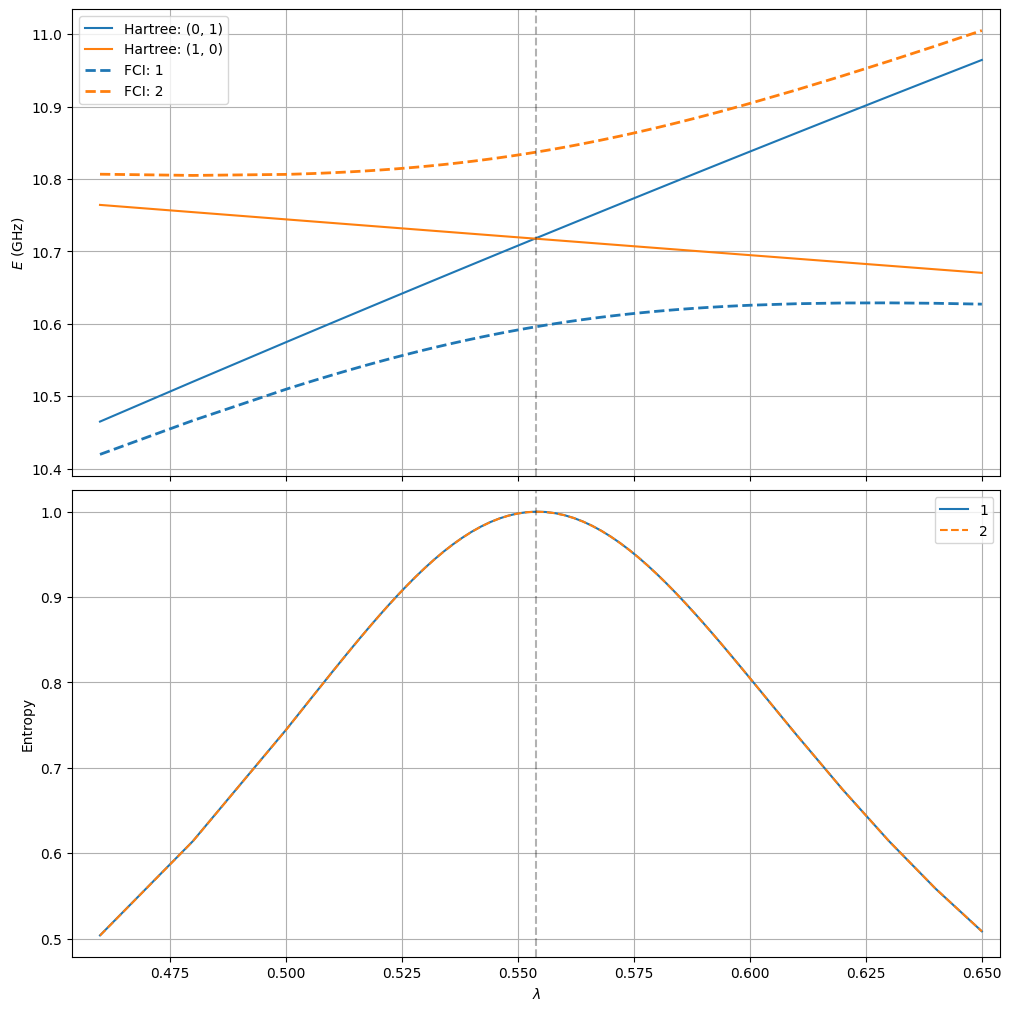

In [33]:
d_keys = sorted(
    list(
        filter(
            lambda x: (x < configs["II"].c_lambda + 0.1)
            & (x > configs["II"].c_lambda - 0.1),
            sorted(lhsds_dict),
        )
    )
)

fig, axs = plt.subplots(
    nrows=2, ncols=1, layout="constrained", sharex=True, figsize=(10, 10)
)

cmap = plt.get_cmap("tab10")


for k, (i, j) in enumerate([(0, 1), (1, 0)]):
    axs[0].plot(
        d_keys,
        [
            (
                lhsds_dict[key].non_int_trans_energies[(i, j)]
                * energy_frequency.to(ureg.GHz).magnitude
            )
            for key in d_keys
        ],
        color=cmap(k),
        label=f"Hartree: {(i, j)}",
    )

for i in range(1, min(lhsds_dict[0].num_two_body_eigenstates, 3)):
    axs[0].plot(
        d_keys,
        [
            (
                lhsds_dict[key].trans_energies[i]
                * energy_frequency.to(ureg.GHz).magnitude
            )
            for key in d_keys
        ],
        "--",
        lw=2,
        color=cmap(i - 1),
        label=f"FCI: {i}",
    )

for i in range(1, min(3, num_two_body_eigenstates)):
    axs[1].plot(
        d_keys,
        [lhsds_dict[key].entropies[i] for key in d_keys],
        "--" if i % 2 == 0 else "-",
        label=f"{i}",
    )
axs[1].set_ylabel(f"Entropy")

for i in range(len(axs)):
    axs[i].grid()
    axs[i].legend()
    axs[i].axvline(configs["II"].c_lambda, ls="--", color="black", alpha=0.3)

axs[0].set_ylabel(f"$E$ (GHz)")
axs[1].set_xlabel(f"$\lambda$")
axs[1].set_xlim(configs["II"].c_lambda - 0.1, configs["II"].c_lambda + 0.1)

plt.show()

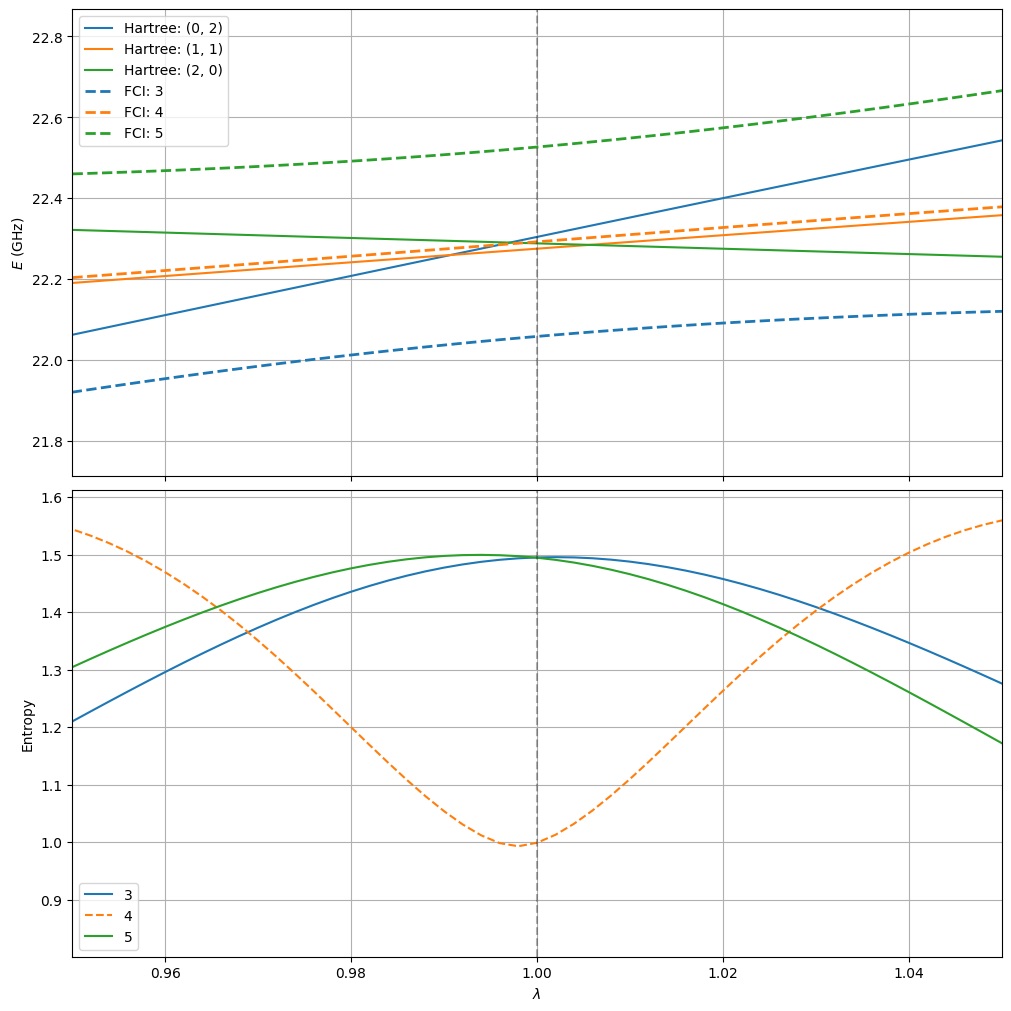

In [38]:
d_keys = sorted(list(filter(lambda x: (x > 0.9) & (x < 1.1), sorted(lhsds_dict))))

fig, axs = plt.subplots(
    nrows=2, ncols=1, layout="constrained", sharex=True, figsize=(10, 10)
)

cmap = plt.get_cmap("tab10")


for k, (i, j) in enumerate([(0, 2), (1, 1), (2, 0)]):
    axs[0].plot(
        d_keys,
        [
            (
                lhsds_dict[key].non_int_trans_energies[(i, j)]
                * energy_frequency.to(ureg.GHz).magnitude
            )
            for key in d_keys
        ],
        color=cmap(k),
        label=f"Hartree: {(i, j)}",
    )

for i in range(3, min(lhsds_dict[0].num_two_body_eigenstates, 6)):
    axs[0].plot(
        d_keys,
        [
            (
                lhsds_dict[key].trans_energies[i]
                * energy_frequency.to(ureg.GHz).magnitude
            )
            for key in d_keys
        ],
        "--",
        lw=2,
        color=cmap(i - 3),
        label=f"FCI: {i}",
    )

for i in range(3, min(6, num_two_body_eigenstates)):
    axs[1].plot(
        d_keys,
        [lhsds_dict[key].entropies[i] for key in d_keys],
        "--" if i % 2 == 0 else "-",
        label=f"{i}",
    )
axs[1].set_ylabel(f"Entropy")

for i in range(len(axs)):
    axs[i].grid()
    axs[i].legend()
    axs[i].axvline(configs["III"].c_lambda, ls="--", color="black", alpha=0.3)

axs[0].set_ylabel(f"$E$ (GHz)")
axs[1].set_xlabel(f"$\lambda$")
axs[1].set_xlim(0.95, 1.05)

plt.show()

In [39]:
m_config = CONFIGS(0)

In [40]:
voltages = np.array(
    [
        [
            (val - m_config[key]) * epsilon.to(ureg.millieV).magnitude
            for key, val in sorted(CONFIGS(l).items())
        ]
        for l in lambdas
    ]
)

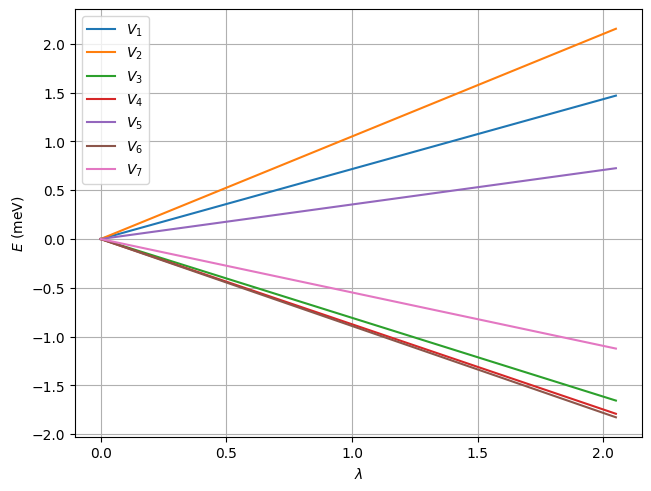

In [41]:
fig, ax = plt.subplots(layout="constrained")

for i in range(1, 8):
    ax.plot(
        lambdas,
        voltages[:, i - 1],
        label=f"$V_{i}$",
    )

ax.grid()
ax.legend()
ax.set_xlabel("$\lambda$")
ax.set_ylabel("$E$ (meV)")
plt.show()

Save voltages as a function of the configurations.

In [42]:
if SAVEFIGS:
    dir_path = os.path.join("dat", f"voltages")
    try:
        os.mkdir(dir_path)
    except FileExistsError:
        pass

    for i in range(1, 8):
        np.savetxt(
            os.path.join(dir_path, f"V{i}.txt"),
            np.concatenate(
                [
                    np.array(lambdas)[:, None],
                    voltages[:, i - 1][:, None],
                ],
                axis=1,
            ),
            header="lambda | voltage [millieV]",
        )

## TODO:

Plot the coefficients as a function of $\lambda$ and the detuning. See if you can estimate the $g$-factor from the interaction as in the Zhao-paper.